# Definição do Problema

## Problema
Classificação binária para prever se `total_kills > média_da_liga` com base no draft

## Target
- Binário (1 = acima da média, 0 = abaixo da média de kills da liga)

## Features
- 10 champions do draft
- Times 
- Liga

## Dataset
- 8000+ jogos

## Aplicação
- Apostas ao vivo

## Métricas de Sucesso
- **Primária**: Precision com threshold otimizado
- **Constraint**: Volume de apostas viável  
- **Business**: ROI positivo

## Estratégia de Avaliação
- Precision-Recall curve para threshold ótimo
- Trade-off volume vs precision
- Backtesting com odds simuladas

## Baseline
- Sempre prever classe majoritária
- Random: 50% accuracy

# DATA LOAD

In [24]:
# === CONFIGURAÇÕES INICIAIS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple  
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss


# Configurações de visualização
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Configurações de apostas
ODDS = 1.83
BREAKEVEN_PROBABILITY = 1 / ODDS
THRESHOLDS = np.round(np.arange(0.50, 0.96, 0.01), 2)

print("✅ Configurações iniciais carregadas")
print(f"📊 Odds: {ODDS} | Probabilidade de Break-even: {BREAKEVEN_PROBABILITY:.3f}")

✅ Configurações iniciais carregadas
📊 Odds: 1.83 | Probabilidade de Break-even: 0.546


In [25]:
# Execute isso no seu notebook para entendermos os dados
import pandas as pd
import numpy as np

df = pd.read_csv("database/database_transformed.csv")  # ou load do seu formato

# Limpeza inicial - manter apenas colunas necessárias
colunas_necessarias = [
    "league",
    "year",
    "date",
    "game",
    "gamelength",
    "patch",
    "t1",
    "t2",
    "top_t1",
    "jung_t1",
    "mid_t1",
    "adc_t1",
    "sup_t1",
    "kills_t1",
    "top_t2",
    "jung_t2",
    "mid_t2",
    "adc_t2",
    "sup_t2",
    "kills_t2",
    "total_kills",
]

df = df[colunas_necessarias]
df.head()

,league,year,date,game,gamelength,patch,t1,t2,top_t1,jung_t1,...,adc_t1,sup_t1,kills_t1,top_t2,jung_t2,mid_t2,adc_t2,sup_t2,kills_t2,total_kills
0,LFL2,2025,2025-01-11 11:11:24,1,26.53,15.01,IziDream,Team Valiant,Gnar,Maokai,...,Jinx,Leona,3,Renekton,Ivern,Orianna,Varus,Braum,13,16
1,LFL2,2025,2025-01-11 12:06:37,1,32.03,15.01,Esprit Shōnen,Skillcamp,K'Sante,Ivern,...,Varus,Rell,21,Renekton,Sejuani,Orianna,Corki,Nautilus,10,31
2,LFL2,2025,2025-01-11 13:07:47,1,29.70,15.01,Karmine Corp Blue Stars,Project Conquerors,Aatrox,Skarner,...,Corki,Alistar,18,Gwen,Kayn,Taliyah,Varus,Rell,22,40
3,LFL2,2025,2025-01-11 14:03:27,1,26.53,15.01,Zerance,Lille Esport,Jayce,Skarner,...,Ezreal,Nautilus,3,K'Sante,Wukong,Ahri,Varus,Rakan,18,21
4,LPL,2025,2025-01-12 09:24:17,1,35.38,15.01,Weibo Gaming,Oh My God,K'Sante,Viego,...,Ashe,Braum,17,Gnar,Nocturne,Orianna,Varus,Neeko,5,22


In [26]:
stats_por_liga = (
    df.groupby("league")["total_kills"]
    .agg(["count", "mean", "std", "min", "max", "median"])
    .round(2)
)

# Adicionar coeficiente de variação
stats_por_liga["cv"] = (stats_por_liga["std"] / stats_por_liga["mean"]).round(3)

# Ordenar por contagem para ver principais ligas
stats_por_liga = stats_por_liga.sort_values("count", ascending=False)
stats_ordenado = stats_por_liga.sort_values("mean", ascending=False)

print("Estatísticas de total_kills por liga (ordenado por média):")
print(stats_ordenado)

Estatísticas de total_kills por liga (ordenado por média):
             count   mean    std  min  max  median     cv
league                                                   
PRMP            73  40.01  11.36   23   89    40.0  0.284
PCS            303  38.55  11.20   16   82    37.0  0.291
HC             192  38.28   8.91   21   78    37.0  0.233
LAS            280  37.74  10.12   17   71    36.0  0.268
VCS            141  36.22   9.92   11   62    36.0  0.274
LJL            374  36.14  10.11   16   72    35.0  0.280
EBL            191  36.14  11.15   14   77    34.0  0.309
LPLOL          160  35.91   9.82   20   77    35.0  0.273
CT              50  35.82  10.53   18   64    34.0  0.294
AL             293  35.73   9.86   15   77    35.0  0.276
HW             114  35.47  10.13   15   63    35.0  0.286
HLL            221  35.46   8.91   14   68    35.0  0.251
Asia Master    114  35.22   9.43   16   62    34.0  0.268
RL             240  34.56   9.73   14   78    34.0  0.282
LRN          

In [27]:
# Ligas para remover (outliers com média muito alta)
ligas_remover = [
    "PRMP",
    "PCS",
    "HC",
    "LAS",
    "VCS",
    "LJL",
    "EBL",
    "LPLOL",
    "CT",
    "AL",
    "HW",
    "HLL",
    "Asia Master",
    "RL",
    "LRN",
    "NEXO",
    "LFL2",
    "ROL",
    "LTA",
]

print(f"Dataset original: {df.shape[0]} jogos")
print(f"Removendo {len(ligas_remover)} ligas outliers...")

# Filtrar dataset
df_filtrado = df[~df["league"].isin(ligas_remover)]

print(f"Dataset filtrado: {df_filtrado.shape[0]} jogos")
print(f"Jogos removidos: {df.shape[0] - df_filtrado.shape[0]}")

Dataset original: 9042 jogos
Removendo 19 ligas outliers...
Dataset filtrado: 5539 jogos
Jogos removidos: 3503


In [28]:
# Atualizar o dataframe principal
matches_df = df_filtrado.copy()
print(f"\nDataset final: {matches_df.shape}")
matches_df.head()


Dataset final: (5539, 21)


,league,year,date,game,gamelength,patch,t1,t2,top_t1,jung_t1,...,adc_t1,sup_t1,kills_t1,top_t2,jung_t2,mid_t2,adc_t2,sup_t2,kills_t2,total_kills
4,LPL,2025,2025-01-12 09:24:17,1,35.38,15.01,Weibo Gaming,Oh My God,K'Sante,Viego,...,Ashe,Braum,17,Gnar,Nocturne,Orianna,Varus,Neeko,5,22
5,LPL,2025,2025-01-12 10:26:00,2,32.53,15.01,Oh My God,Weibo Gaming,Rumble,Maokai,...,Jhin,Rell,11,Jayce,Wukong,Viktor,Miss Fortune,Rakan,18,29
7,LPL,2025,2025-01-12 11:21:40,3,33.57,15.01,Oh My God,Weibo Gaming,Aatrox,Zyra,...,Ziggs,Leona,18,Jax,Sejuani,Sylas,Jinx,Poppy,22,40
11,LCKC,2025,2025-01-13 05:08:44,1,30.93,15.01,Nongshim Esports Academy,DN Freecs Challengers,K'Sante,Maokai,...,Jhin,Leona,7,Jayce,Sejuani,Taliyah,Caitlyn,Braum,11,18
12,LCKC,2025,2025-01-13 06:01:40,2,30.65,15.01,DN Freecs Challengers,Nongshim Esports Academy,Renekton,Wukong,...,Ezreal,Rell,17,Gnar,Vi,Akali,Varus,Rakan,11,28


=== ANÁLISE DE GAME LENGTH ===
Shape do dataset: (5539, 21)

Estatísticas básicas:
count    5539.000000
mean       32.587503
std         5.431518
min        18.550000
25%        28.620000
50%        31.470000
75%        35.570000
max        60.350000
Name: gamelength, dtype: float64

Missing values em gamelength: 0

=== OUTLIERS (Método IQR) ===
Limite inferior: 18.20 minutos
Limite superior: 45.99 minutos
Outliers encontrados: 125 jogos (2.26%)

=== OUTLIERS (Z-score > 3) ===
Outliers encontrados: 56 jogos (1.01%)

=== OUTLIERS EXTREMOS ===
5 jogos mais curtos:
      gamelength  total_kills  league
8299       18.55           28     TCL
7329       18.92           28     LRS
198        18.97           16  LVP SL
6378       19.05           21     NLC
243        19.50           20     LIT

5 jogos mais longos:
      gamelength  total_kills league
7732       60.35           61    LFL
134        59.30           54    LEC
6546       56.90           66     HM
2551       55.65           41    

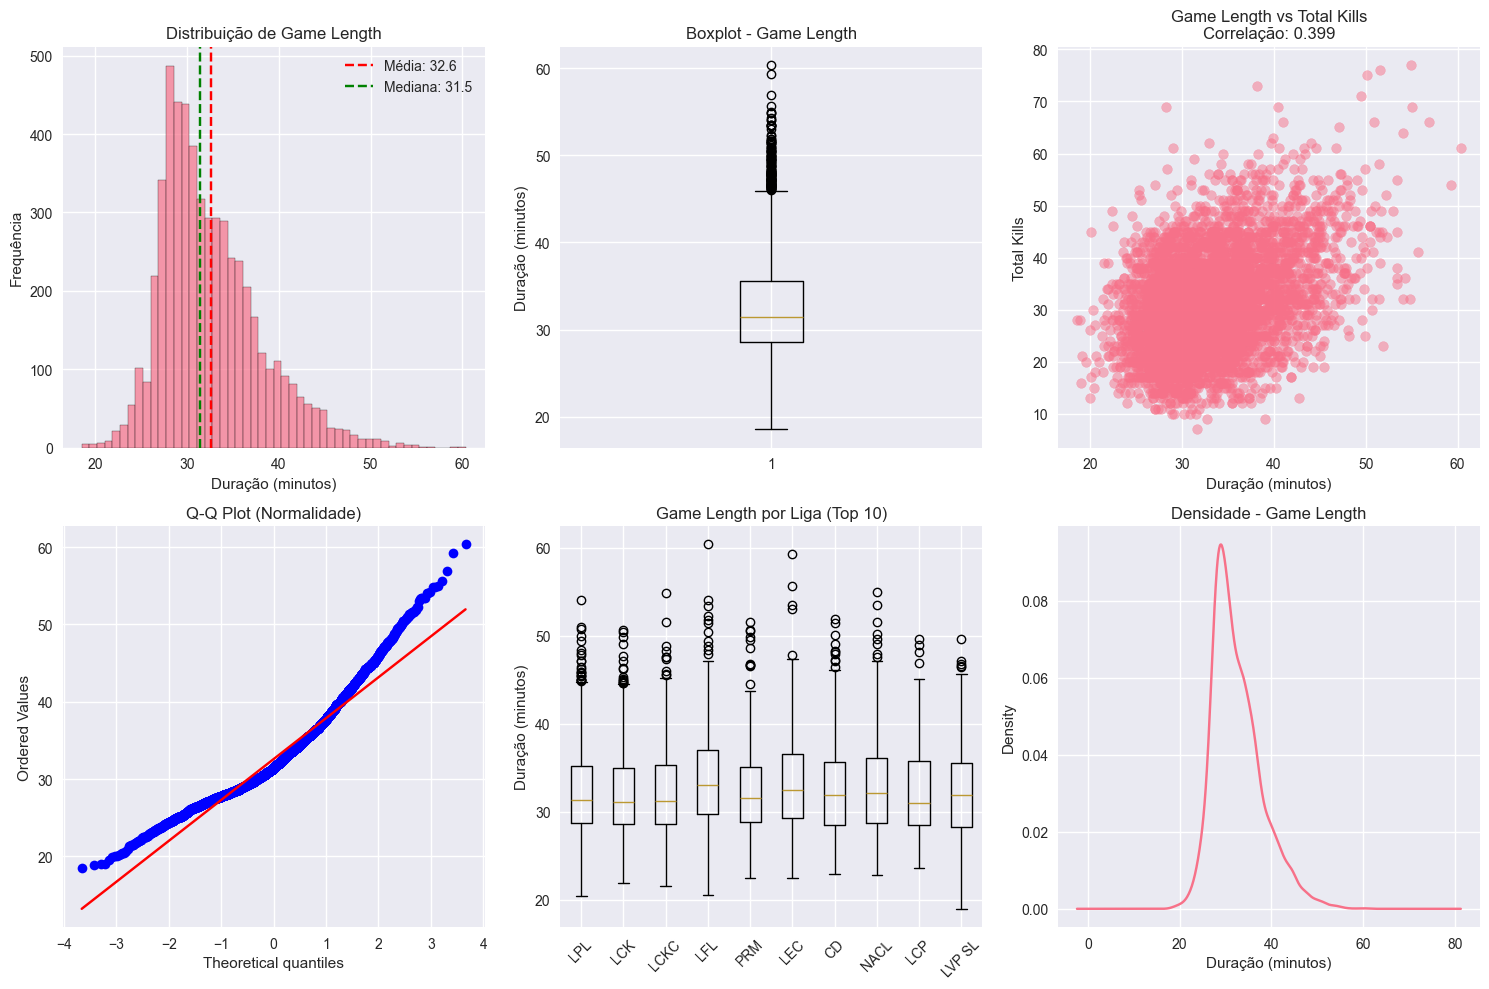


=== TESTE DE NORMALIDADE (Shapiro-Wilk) ===
Estatística: 0.946741
P-valor: 0.000000
Distribuição normal: Não

=== RECOMENDAÇÕES ===
✅ Quantidade razoável de outliers (<5%)
✅ Correlação moderada com total_kills (0.399)
- Game length pode ser feature útil para o modelo


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Análise básica de game length
print("=== ANÁLISE DE GAME LENGTH ===")
print(f"Shape do dataset: {matches_df.shape}")
print(f"\nEstatísticas básicas:")
print(matches_df["gamelength"].describe())

# Verificar missing values
print(f"\nMissing values em gamelength: {matches_df['gamelength'].isnull().sum()}")

# Identificar outliers usando IQR
Q1 = matches_df["gamelength"].quantile(0.25)
Q3 = matches_df["gamelength"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = matches_df[
    (matches_df["gamelength"] < lower_bound) | (matches_df["gamelength"] > upper_bound)
]
print(f"\n=== OUTLIERS (Método IQR) ===")
print(f"Limite inferior: {lower_bound:.2f} minutos")
print(f"Limite superior: {upper_bound:.2f} minutos")
print(
    f"Outliers encontrados: {len(outliers_iqr)} jogos ({len(outliers_iqr) / len(matches_df) * 100:.2f}%)"
)

# Outliers usando Z-score
z_scores = np.abs(stats.zscore(matches_df["gamelength"].dropna()))
outliers_zscore = matches_df[z_scores > 3]
print(f"\n=== OUTLIERS (Z-score > 3) ===")
print(
    f"Outliers encontrados: {len(outliers_zscore)} jogos ({len(outliers_zscore) / len(matches_df) * 100:.2f}%)"
)

# Mostrar alguns outliers extremos
print(f"\n=== OUTLIERS EXTREMOS ===")
print("5 jogos mais curtos:")
shortest = matches_df.nsmallest(5, "gamelength")[
    ["gamelength", "total_kills", "league"]
]
print(shortest)

print("\n5 jogos mais longos:")
longest = matches_df.nlargest(5, "gamelength")[["gamelength", "total_kills", "league"]]
print(longest)

# Análise por liga
print(f"\n=== DISTRIBUIÇÃO POR LIGA ===")
league_stats = (
    matches_df.groupby("league")["gamelength"]
    .agg(["count", "mean", "std", "min", "max"])
    .round(2)
)
league_stats = league_stats.sort_values("mean", ascending=False)
print(league_stats)

# Correlação com total_kills
correlation = matches_df["gamelength"].corr(matches_df["total_kills"])
print(f"\n=== CORRELAÇÃO ===")
print(f"Correlação gamelength vs total_kills: {correlation:.3f}")

# Visualizações
plt.figure(figsize=(15, 10))

# Histograma
plt.subplot(2, 3, 1)
plt.hist(matches_df["gamelength"], bins=50, alpha=0.7, edgecolor="black")
plt.title("Distribuição de Game Length")
plt.xlabel("Duração (minutos)")
plt.ylabel("Frequência")
plt.axvline(
    matches_df["gamelength"].mean(),
    color="red",
    linestyle="--",
    label=f"Média: {matches_df['gamelength'].mean():.1f}",
)
plt.axvline(
    matches_df["gamelength"].median(),
    color="green",
    linestyle="--",
    label=f"Mediana: {matches_df['gamelength'].median():.1f}",
)
plt.legend()

# Boxplot
plt.subplot(2, 3, 2)
plt.boxplot(matches_df["gamelength"])
plt.title("Boxplot - Game Length")
plt.ylabel("Duração (minutos)")

# Scatter plot: gamelength vs total_kills
plt.subplot(2, 3, 3)
plt.scatter(matches_df["gamelength"], matches_df["total_kills"], alpha=0.5)
plt.title(f"Game Length vs Total Kills\nCorrelação: {correlation:.3f}")
plt.xlabel("Duração (minutos)")
plt.ylabel("Total Kills")

# Q-Q plot para normalidade
plt.subplot(2, 3, 4)
stats.probplot(matches_df["gamelength"], dist="norm", plot=plt)
plt.title("Q-Q Plot (Normalidade)")

# Distribuição por liga (top 10)
plt.subplot(2, 3, 5)
top_leagues = matches_df["league"].value_counts().head(10).index
league_data = [
    matches_df[matches_df["league"] == league]["gamelength"] for league in top_leagues
]
plt.boxplot(league_data, labels=top_leagues)
plt.xticks(rotation=45)
plt.title("Game Length por Liga (Top 10)")
plt.ylabel("Duração (minutos)")

# Densidade
plt.subplot(2, 3, 6)
matches_df["gamelength"].plot(kind="density")
plt.title("Densidade - Game Length")
plt.xlabel("Duração (minutos)")

plt.tight_layout()
plt.show()

# Teste de normalidade
shapiro_stat, shapiro_p = stats.shapiro(
    matches_df["gamelength"].sample(5000)
)  # Sample para performance
print(f"\n=== TESTE DE NORMALIDADE (Shapiro-Wilk) ===")
print(f"Estatística: {shapiro_stat:.6f}")
print(f"P-valor: {shapiro_p:.6f}")
print(f"Distribuição normal: {'Não' if shapiro_p < 0.05 else 'Sim'}")

# Recomendações para outliers
print(f"\n=== RECOMENDAÇÕES ===")
if len(outliers_iqr) > len(matches_df) * 0.05:  # Mais de 5% outliers
    print("⚠️  Muitos outliers detectados (>5%)")
    print(
        "- Considere investigar jogos muito curtos (<15 min) ou muito longos (>45 min)"
    )
    print("- Possíveis remake/surrender early ou jogos técnicos")
else:
    print("✅ Quantidade razoável de outliers (<5%)")

if correlation > 0.3:
    print(f"✅ Correlação moderada com total_kills ({correlation:.3f})")
    print("- Game length pode ser feature útil para o modelo")
else:
    print(f"⚠️  Correlação fraca com total_kills ({correlation:.3f})")

In [30]:
# Remover outliers de gamelength usando método IQR
print("=== REMOVENDO OUTLIERS DE GAMELENGTH ===")

print(f"Dataset original: {matches_df.shape[0]} jogos")

# Calcular limites IQR
Q1 = matches_df["gamelength"].quantile(0.25)
Q3 = matches_df["gamelength"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Limite inferior: {lower_bound:.2f} minutos")
print(f"Limite superior: {upper_bound:.2f} minutos")

# Identificar outliers
outliers_mask = (matches_df["gamelength"] < lower_bound) | (
    matches_df["gamelength"] > upper_bound
)
outliers_count = outliers_mask.sum()

print(
    f"Outliers identificados: {outliers_count} jogos ({outliers_count / len(matches_df) * 100:.2f}%)"
)

# Remover outliers
df_clean = matches_df[~outliers_mask].copy()

print(f"Dataset após remoção: {df_clean.shape[0]} jogos")
print(f"Jogos removidos: {outliers_count}")

# Verificar nova distribuição
print(f"\nNova distribuição de gamelength:")
print(df_clean["gamelength"].describe().round(2))

# Remover coluna gamelength
df_clean = df_clean.drop(["gamelength", "year", "date", "patch", "game"], axis=1)

print(f"\nDataset final após remover coluna gamelength:")
print(f"Shape: {df_clean.shape}")
print(f"Colunas restantes: {list(df_clean.columns)}")

# Atualizar o dataframe principal
matches_df = df_clean.copy()

print(f"\n✅ Outliers removidos e coluna gamelength excluída")
print(f"Dataset final: {matches_df.shape}")

=== REMOVENDO OUTLIERS DE GAMELENGTH ===
Dataset original: 5539 jogos
Limite inferior: 18.20 minutos
Limite superior: 45.99 minutos
Outliers identificados: 125 jogos (2.26%)
Dataset após remoção: 5414 jogos
Jogos removidos: 125

Nova distribuição de gamelength:
count    5414.00
mean       32.20
std         4.84
min        18.55
25%        28.58
50%        31.30
75%        35.27
max        45.92
Name: gamelength, dtype: float64

Dataset final após remover coluna gamelength:
Shape: (5414, 16)
Colunas restantes: ['league', 't1', 't2', 'top_t1', 'jung_t1', 'mid_t1', 'adc_t1', 'sup_t1', 'kills_t1', 'top_t2', 'jung_t2', 'mid_t2', 'adc_t2', 'sup_t2', 'kills_t2', 'total_kills']

✅ Outliers removidos e coluna gamelength excluída
Dataset final: (5414, 16)


In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

ROLES = ["top", "jung", "mid", "adc", "sup"]


def calculate_champion_impacts_simple(df, min_games=15):
    overall_mean = df["total_kills"].mean()
    champion_columns = [f"{role}_{team}" for role in ROLES for team in ["t1", "t2"]]
    champion_impacts = {}
    champion_counts = {}

    for col in champion_columns:
        for champion in df[col].dropna().unique():
            if champion not in champion_counts:
                champion_counts[champion] = 0
                champion_impacts[champion] = []

            champion_games = df[df[col] == champion]["total_kills"]
            champion_impacts[champion].extend(champion_games.tolist())
            champion_counts[champion] += len(champion_games)

    final_impacts = {}
    for champion in champion_impacts:
        if champion_counts[champion] >= min_games:
            mean_kills = np.mean(champion_impacts[champion])
            final_impacts[champion] = mean_kills - overall_mean
        else:
            final_impacts[champion] = 0.0

    return final_impacts, overall_mean, champion_counts


def calculate_champion_impacts_relaxed(df, min_games=20, alpha=0.15):
    overall_mean = df["total_kills"].mean()
    champion_columns = [f"{role}_{team}" for role in ROLES for team in ["t1", "t2"]]
    champion_impacts = {}
    champion_counts = {}

    for col in champion_columns:
        for champion in df[col].dropna().unique():
            if champion not in champion_counts:
                champion_counts[champion] = 0
                champion_impacts[champion] = []

            champion_games = df[df[col] == champion]["total_kills"]
            champion_impacts[champion].extend(champion_games.tolist())
            champion_counts[champion] += len(champion_games)

    final_impacts = {}
    for champion in champion_impacts:
        if champion_counts[champion] >= min_games:
            games = champion_impacts[champion]
            mean_kills = np.mean(games)
            impact = mean_kills - overall_mean

            if len(games) >= 5:
                t_stat, p_val = stats.ttest_1samp(games, overall_mean)
                final_impacts[champion] = impact if p_val < alpha else 0.0
            else:
                final_impacts[champion] = impact if abs(impact) > 1.5 else 0.0
        else:
            final_impacts[champion] = 0.0

    return final_impacts, overall_mean, champion_counts


def create_dataset(df, champion_impacts):
    df_new = df.copy()

    league_means = df_new.groupby("league")["total_kills"].mean()
    df_new["league_mean_kills"] = df_new["league"].map(league_means)
    df_new["target"] = (df_new["total_kills"] > df_new["league_mean_kills"]).astype(int)

    all_teams = pd.concat([df_new["t1"], df_new["t2"]]).unique()
    team_means = {}
    for team in all_teams:
        team_games = df_new[(df_new["t1"] == team) | (df_new["t2"] == team)]
        team_means[team] = team_games["total_kills"].mean()

    df_new["mean_total_kills_t1"] = df_new["t1"].map(team_means)
    df_new["mean_total_kills_t2"] = df_new["t2"].map(team_means)

    for role in ROLES:
        for team in ["t1", "t2"]:
            col = f"{role}_{team}"
            df_new[f"impact_{role}_{team}"] = (
                df_new[col].map(champion_impacts).fillna(0.0)
            )

    columns_final = [
        "total_kills",
        "target",
        "league",
        "league_mean_kills",
        "mean_total_kills_t1",
        "mean_total_kills_t2",
    ] + [f"impact_{role}_{team}" for role in ROLES for team in ["t1", "t2"]]

    return df_new[columns_final]


print("=== CRIANDO DATASET 1: SEM TESTE ===")
impacts_simple, _, counts_simple = calculate_champion_impacts_simple(
    matches_df, min_games=15
)
df_high_champ_impact = create_dataset(matches_df, impacts_simple)

impactos_sig_simple = {k: v for k, v in impacts_simple.items() if v != 0.0}
print(f"Campeões com impacto: {len(impactos_sig_simple)}")
print(f"Dataset shape: {df_high_champ_impact.shape}")
print(f"Balanceamento target: {df_high_champ_impact['target'].value_counts()}")

print("\n=== CRIANDO DATASET 2: TESTE RELAXADO ===")
impacts_relaxed, _, counts_relaxed = calculate_champion_impacts_relaxed(
    matches_df, min_games=20, alpha=0.15
)
df_low_champ_impact = create_dataset(matches_df, impacts_relaxed)

impactos_sig_relaxed = {k: v for k, v in impacts_relaxed.items() if v != 0.0}
print(f"Campeões com impacto: {len(impactos_sig_relaxed)}")
print(f"Dataset shape: {df_low_champ_impact.shape}")
print(f"Balanceamento target: {df_low_champ_impact['target'].value_counts()}")

df_high_champ_impact.to_csv("dataset_ml_simple.csv", index=False)
df_low_champ_impact.to_csv("dataset_ml_relaxed.csv", index=False)

print(f"\nDatasets salvos:")
print(f"- dataset_ml_simple.csv ({len(impactos_sig_simple)} campeões)")
print(f"- dataset_ml_relaxed.csv ({len(impactos_sig_relaxed)} campeões)")

=== CRIANDO DATASET 1: SEM TESTE ===
Campeões com impacto: 137
Dataset shape: (5414, 16)
Balanceamento target: target
0    2848
1    2566
Name: count, dtype: int64

=== CRIANDO DATASET 2: TESTE RELAXADO ===
Campeões com impacto: 65
Dataset shape: (5414, 16)
Balanceamento target: target
0    2848
1    2566
Name: count, dtype: int64

Datasets salvos:
- dataset_ml_simple.csv (137 campeões)
- dataset_ml_relaxed.csv (65 campeões)


# Utilizando low impact champ

✅ Variável target criada:
   - Total de partidas: 5414
   - Partidas com kills acima da média: 2566 (47.4%)


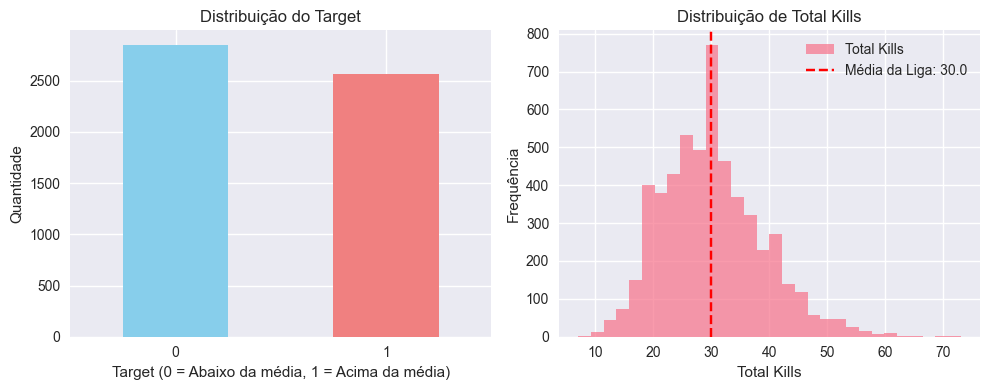

In [32]:
# === CRIAÇÃO DA VARIÁVEL TARGET ===

if not df_low_champ_impact.empty:
    # Criar target binário
    df_low_champ_impact["target"] = (
        df_low_champ_impact["total_kills"] > df_low_champ_impact["league_mean_kills"]
    ).astype(int)

    print("✅ Variável target criada:")
    print(f"   - Total de partidas: {len(df_low_champ_impact)}")
    print(
        f"   - Partidas com kills acima da média: {df_low_champ_impact['target'].sum()} ({df_low_champ_impact['target'].mean():.1%})"
    )

    # Distribuição do target
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    df_low_champ_impact["target"].value_counts().plot(
        kind="bar", color=["skyblue", "lightcoral"]
    )
    plt.title("Distribuição do Target")
    plt.xlabel("Target (0 = Abaixo da média, 1 = Acima da média)")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    df_low_champ_impact["total_kills"].hist(bins=30, alpha=0.7, label="Total Kills")
    plt.axvline(
        df_low_champ_impact["league_mean_kills"].mean(),
        color="red",
        linestyle="--",
        label=f"Média da Liga: {df_low_champ_impact['league_mean_kills'].mean():.1f}",
    )
    plt.title("Distribuição de Total Kills")
    plt.xlabel("Total Kills")
    plt.ylabel("Frequência")
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível criar a variável target")

In [33]:
# === ANÁLISE DAS FEATURES ===

if not df_low_champ_impact.empty:
    # Identificar colunas a serem excluídas
    excluded_columns = ["total_kills", "target"]
    feature_columns = [
        col for col in df_low_champ_impact.columns if col not in excluded_columns
    ]

    print(f"🎯 Features disponíveis: {len(feature_columns)}")
    print("📋 Lista de features:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")

    # Estatísticas básicas das features
    if feature_columns:
        print(f"\n📊 Estatísticas das features:")
        features_stats = df_low_champ_impact[feature_columns].describe()
        display(features_stats.head(8))

        # Verificar valores missing
        missing_values = df_low_champ_impact[feature_columns].isnull().sum()
        if missing_values.any():
            print("\n⚠️  Valores missing encontrados:")
            for col, missing_count in missing_values[missing_values > 0].items():
                print(
                    f"   - {col}: {missing_count} valores missing ({missing_count / len(df_low_champ_impact):.1%})"
                )
        else:
            print("✅ Nenhum valor missing nas features")

else:
    print("❌ Dataset vazio - não foi possível analisar as features")

🎯 Features disponíveis: 14
📋 Lista de features:
    1. league
    2. league_mean_kills
    3. mean_total_kills_t1
    4. mean_total_kills_t2
    5. impact_top_t1
    6. impact_top_t2
    7. impact_jung_t1
    8. impact_jung_t2
    9. impact_mid_t1
   10. impact_mid_t2
   11. impact_adc_t1
   12. impact_adc_t2
   13. impact_sup_t1
   14. impact_sup_t2

📊 Estatísticas das features:


,league_mean_kills,mean_total_kills_t1,mean_total_kills_t2,impact_top_t1,impact_top_t2,impact_jung_t1,impact_jung_t2,impact_mid_t1,impact_mid_t2,impact_adc_t1,impact_adc_t2,impact_sup_t1,impact_sup_t2
count,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000
mean,29.988918,29.956188,30.021647,-0.011465,0.021594,0.012293,0.004417,0.012372,0.057366,-0.068203,-0.048298,-0.014591,-0.022570
std,1.910771,2.676128,2.672150,0.811166,0.931262,0.874793,0.883624,0.604018,0.611962,0.692643,0.695313,1.189980,1.158241
min,26.645833,24.461538,24.461538,-3.118788,-3.118788,-3.118788,-3.118788,-2.688918,-2.688918,-2.391092,-2.391092,-4.015233,-4.015233
25%,28.729323,28.188235,28.212121,-0.456796,-0.456796,-0.578437,-0.578437,-0.387355,0.000000,-0.377673,-0.377673,-0.869089,-0.869089
50%,29.813776,29.845361,29.928571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,31.324503,31.346154,0.601701,0.601701,0.327538,0.327538,0.000000,0.000000,0.461004,0.442946,0.524224,0.524224
max,32.956731,61.000000,61.000000,5.796797,5.796797,3.399971,3.399971,4.974045,4.974045,5.796797,5.796797,3.753350,3.753350


✅ Nenhum valor missing nas features


📈 Matriz de Correlação com o Target:
🔍 Features com correlação significativa com o target (|r| > 0.05):
   - mean_total_kills_t2: 0.126
   - mean_total_kills_t1: 0.121
   - impact_sup_t1: 0.121
   - impact_sup_t2: 0.099
   - impact_jung_t1: 0.092
   - impact_jung_t2: 0.091
   - impact_top_t2: 0.074
   - impact_adc_t1: 0.074
   - impact_top_t1: 0.068
   - impact_mid_t2: 0.066
   - impact_adc_t2: 0.050
   - impact_mid_t1: 0.034


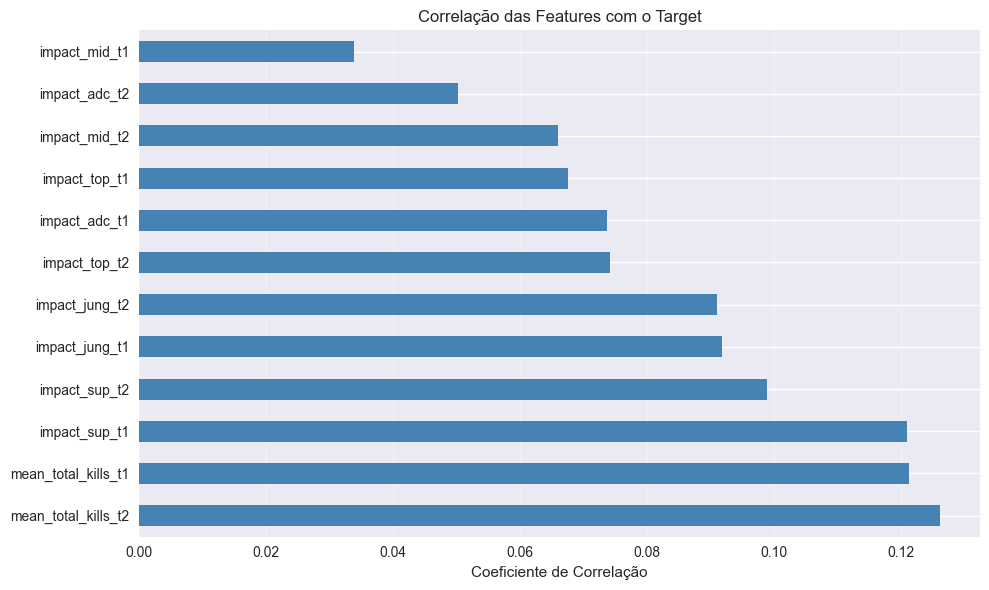

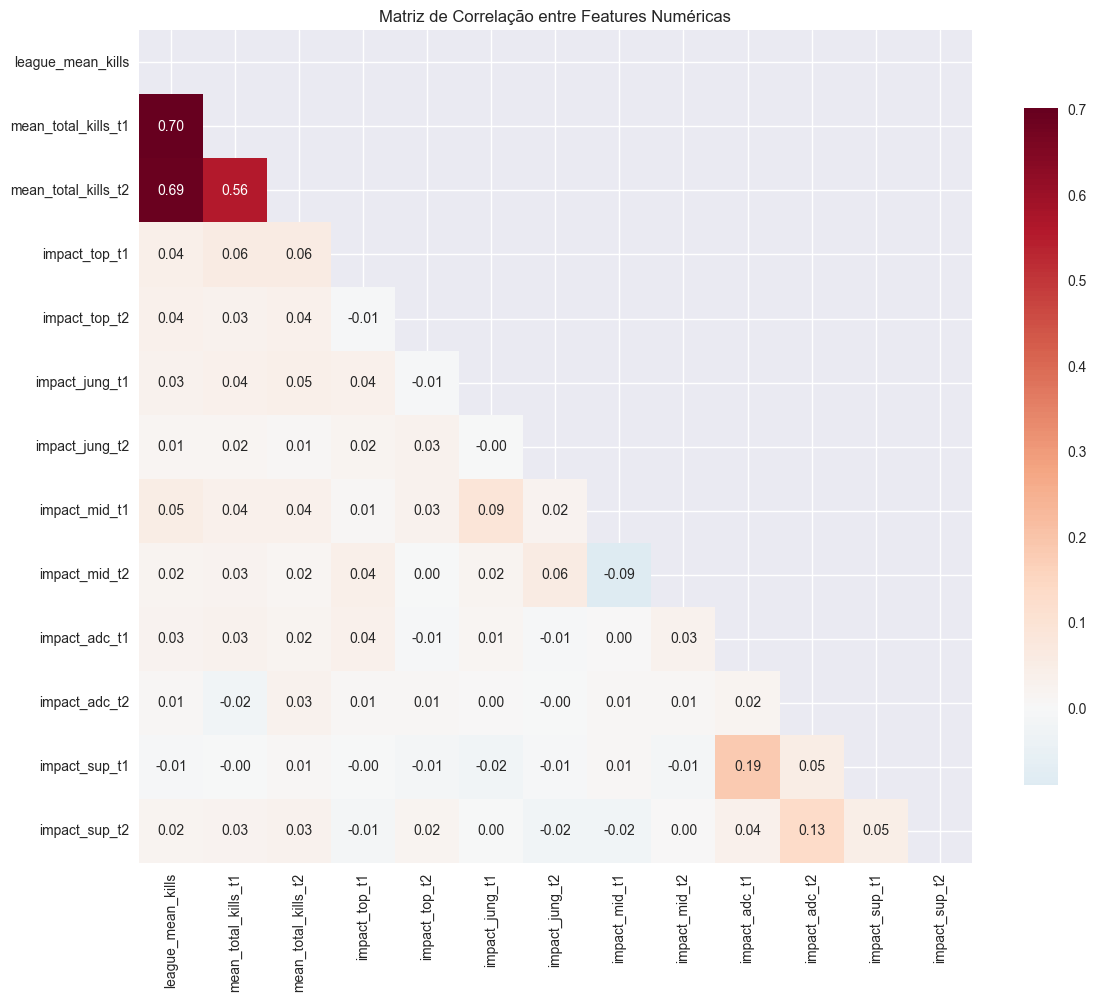

In [34]:
# === ANÁLISE DE CORRELAÇÕES ===

if not df_low_champ_impact.empty:
    # Calcular matriz de correlação apenas com features numéricas
    numeric_features = df_low_champ_impact[feature_columns].select_dtypes(
        include=[np.number]
    )

    print("📈 Matriz de Correlação com o Target:")

    # Correlações com o target
    target_correlations = (
        df_low_champ_impact[numeric_features.columns.tolist() + ["target"]]
        .corr()["target"]
        .sort_values(ascending=False)
    )

    # Filtrar apenas correlações significativas (abs > 0.05)
    significant_corrs = target_correlations[abs(target_correlations) > 0.03]
    significant_corrs = significant_corrs.drop("target", errors="ignore")

    if len(significant_corrs) > 0:
        print("🔍 Features com correlação significativa com o target (|r| > 0.05):")
        for feature, corr in significant_corrs.items():
            print(f"   - {feature}: {corr:.3f}")

        # Plot das correlações mais importantes
        plt.figure(figsize=(10, 6))
        significant_corrs.plot(kind="barh", color="steelblue")
        plt.title("Correlação das Features com o Target")
        plt.xlabel("Coeficiente de Correlação")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Nenhuma feature com correlação significativa (|r| > 0.04) encontrada")

    # Matriz de correlação completa
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_features.corr()

    # Máscara para mostrar apenas metade da matriz
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        cmap="RdBu_r",
        center=0,
        square=True,
        fmt=".2f",
        cbar_kws={"shrink": 0.8},
    )
    plt.title("Matriz de Correlação entre Features Numéricas")
    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível calcular correlações")

In [35]:
# === ANÁLISE DETALHADA DAS FEATURES MAIS IMPORTANTES ===

if not df_low_champ_impact.empty and len(significant_corrs) > 0:
    # Selecionar top 6 features por correlação absoluta
    top_features = (
        significant_corrs.abs().sort_values(ascending=False).head(6).index.tolist()
    )

    print(f"🔬 Analisando as {len(top_features)} features mais correlacionadas:")
    for i, feature in enumerate(top_features, 1):
        print(f"   {i}. {feature} (corr: {significant_corrs[feature]:.3f})")

    # Plot detalhado de cada feature
    n_features = len(top_features)
    n_cols = 3

🔬 Analisando as 6 features mais correlacionadas:
   1. mean_total_kills_t2 (corr: 0.126)
   2. mean_total_kills_t1 (corr: 0.121)
   3. impact_sup_t1 (corr: 0.121)
   4. impact_sup_t2 (corr: 0.099)
   5. impact_jung_t1 (corr: 0.092)
   6. impact_jung_t2 (corr: 0.091)


✅ Divisão treino-teste realizada:
   - Shape do X_train: (4331, 14)
   - Shape do X_test: (1083, 14)
   - Proporção do target no treino: 0.474
   - Proporção do target no teste: 0.474


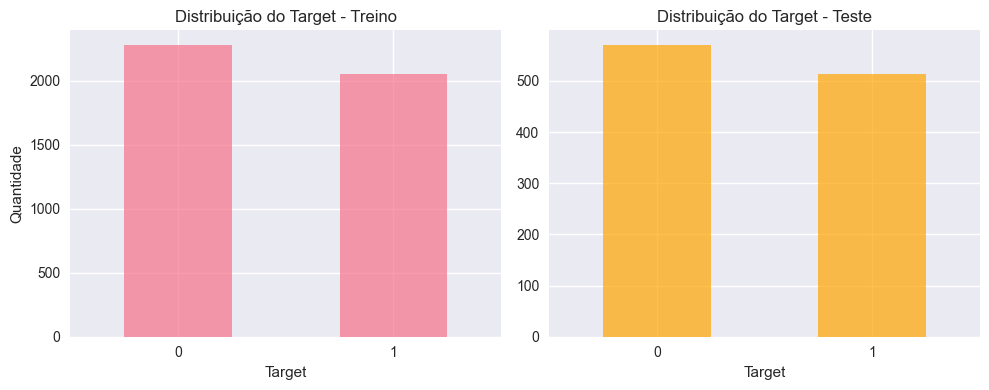

In [36]:
# === DIVISÃO TREINO-TESTE ===

from sklearn.model_selection import train_test_split

if not df_low_champ_impact.empty:
    # Separar features e target
    X = df_low_champ_impact[feature_columns]
    y = df_low_champ_impact["target"].values

    # Dividir em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

    print("✅ Divisão treino-teste realizada:")
    print(f"   - Shape do X_train: {X_train.shape}")
    print(f"   - Shape do X_test: {X_test.shape}")
    print(f"   - Proporção do target no treino: {y_train.mean():.3f}")
    print(f"   - Proporção do target no teste: {y_test.mean():.3f}")

    # Visualizar a divisão
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    pd.Series(y_train).value_counts().sort_index().plot(
        kind="bar", alpha=0.7, label="Treino"
    )
    plt.title("Distribuição do Target - Treino")
    plt.xlabel("Target")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    pd.Series(y_test).value_counts().sort_index().plot(
        kind="bar", alpha=0.7, label="Teste", color="orange"
    )
    plt.title("Distribuição do Target - Teste")
    plt.xlabel("Target")
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível dividir os dados")

In [37]:
# === CONFIGURAÇÃO DO MODELO E VALIDAÇÃO CRUZADA ===

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Configurar validação cruzada
N_SPLITS = 5
N_REPEATS = 3
cross_validator = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42
)

# Configurar pipeline do modelo
model_pipeline = Pipeline(
    [
        ("feature_scaler", StandardScaler()),
        ("classifier", LogisticRegression(C=10.0, max_iter=1000, random_state=42)),
    ]
)

print("✅ Configuração do Modelo:")
print(f"   - Algoritmo: Logistic Regression")
print(f"   - Regularização (C): 10.0")
print(f"   - Validação Cruzada: {N_SPLITS} folds, {N_REPEATS} repetições")

# Verificar se temos dados para prosseguir
if not df_low_champ_impact.empty:
    # Preparar features e target
    excluded_columns = ["total_kills", "league", "target"]
    feature_columns = [
        col for col in df_low_champ_impact.columns if col not in excluded_columns
    ]

    X = df_low_champ_impact[feature_columns]
    y = df_low_champ_impact["target"].values

    print(f"\n✅ Dados preparados para modelagem:")
    print(f"   - Shape dos features: {X.shape}")
    print(f"   - Distribuição do target: {y.mean():.1%} positivos")

    # Divisão treino-teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

    print(f"\n📊 Divisão Treino-Teste:")
    print(f"   - Treino: {X_train.shape[0]} amostras")
    print(f"   - Teste: {X_test.shape[0]} amostras")
    print(f"   - Proporção target no treino: {y_train.mean():.1%}")
    print(f"   - Proporção target no teste: {y_test.mean():.1%}")

else:
    print("❌ Dataset vazio - não foi possível configurar o modelo")

✅ Configuração do Modelo:
   - Algoritmo: Logistic Regression
   - Regularização (C): 10.0
   - Validação Cruzada: 5 folds, 3 repetições

✅ Dados preparados para modelagem:
   - Shape dos features: (5414, 13)
   - Distribuição do target: 47.4% positivos

📊 Divisão Treino-Teste:
   - Treino: 4331 amostras
   - Teste: 1083 amostras
   - Proporção target no treino: 47.4%
   - Proporção target no teste: 47.4%


In [38]:
# === FUNÇÕES PARA CÁLCULO DE MÉTRICAS DE APOSTAS ===


def calculate_betting_metrics(true_labels, predicted_probs, threshold, odds=ODDS):
    """
    Calcula métricas de performance para apostas esportivas.

    Args:
        true_labels: Array com os rótulos verdadeiros (0 ou 1)
        predicted_probs: Array com as probabilidades previstas
        threshold: Limiar para decisão de aposta
        odds: Odds oferecidas pela casa de apostas

    Returns:
        Dicionário com métricas de apostas
    """
    # Decisões de aposta baseadas no threshold
    bet_decisions = (predicted_probs >= threshold).astype(int)
    total_bets = bet_decisions.sum()

    if total_bets == 0:
        return {
            "total_bets": 0,
            "successful_bets": 0,
            "win_rate": 0.0,
            "net_profit": 0.0,
            "return_on_investment": 0.0,
        }

    # Calcular acertos e erros
    successful_bets = ((bet_decisions == 1) & (true_labels == 1)).sum()
    failed_bets = total_bets - successful_bets

    # Calcular lucro e ROI
    net_profit = successful_bets * (odds - 1) - failed_bets
    return_on_investment = (net_profit / total_bets) * 100

    return {
        "total_bets": int(total_bets),
        "successful_bets": int(successful_bets),
        "win_rate": successful_bets / total_bets,
        "net_profit": float(net_profit),
        "return_on_investment": float(return_on_investment),
    }


def evaluate_probabilistic_metrics(true_labels, predicted_probs):
    """
    Avalia métricas probabilísticas padrão.
    """
    return {
        "auc_roc": roc_auc_score(true_labels, predicted_probs),
        "brier_score": brier_score_loss(true_labels, predicted_probs),
        "log_loss": log_loss(true_labels, predicted_probs),
    }


print("✅ Funções para métricas de apostas definidas")

✅ Funções para métricas de apostas definidas


🔄 Executando validação cruzada...
   ✅ Fold 5 concluído - AUC: 0.670
   ✅ Fold 10 concluído - AUC: 0.661
   ✅ Fold 15 concluído - AUC: 0.665
🎯 Validação cruzada concluída: 15 folds totais

📊 MÉTRICAS DAS PREVISÕES OUT-OF-FOLD (TREINO):
   - AUC-ROC: 0.676
   - Brier Score: 0.2258
   - Log Loss: 0.6428


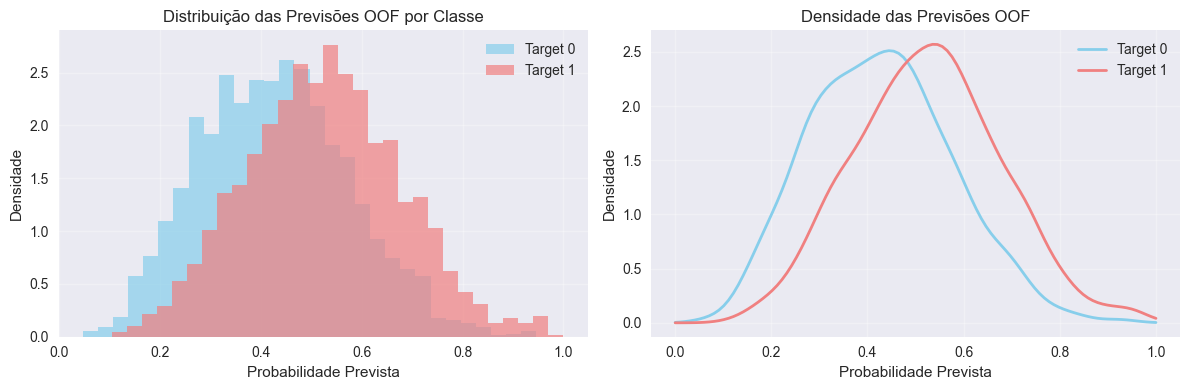

In [39]:
# === VALIDAÇÃO CRUZADA E PREVISÕES OUT-OF-FOLD ===

if not df_low_champ_impact.empty:
    # Inicializar array para as previsões OOF
    oof_predictions = np.zeros(len(y_train))

    print("🔄 Executando validação cruzada...")

    # Contador de folds para acompanhamento
    fold_counter = 0

    # RepeatedStratifiedKFold: n_splits * n_repeats folds no total
    for train_idx, val_idx in cross_validator.split(X_train, y_train):
        fold_counter += 1

        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Treinar e prever no fold de validação
        model_pipeline.fit(X_train_fold, y_train_fold)
        oof_predictions[val_idx] = model_pipeline.predict_proba(X_val_fold)[:, 1]

        # Mostrar progresso a cada 5 folds
        if fold_counter % 5 == 0:
            fold_auc = roc_auc_score(y_val_fold, oof_predictions[val_idx])
            print(f"   ✅ Fold {fold_counter} concluído - AUC: {fold_auc:.3f}")

    print(f"🎯 Validação cruzada concluída: {fold_counter} folds totais")

    # Calcular métricas OOF
    oof_metrics = evaluate_probabilistic_metrics(y_train, oof_predictions)

    print("\n📊 MÉTRICAS DAS PREVISÕES OUT-OF-FOLD (TREINO):")
    print(f"   - AUC-ROC: {oof_metrics['auc_roc']:.3f}")
    print(f"   - Brier Score: {oof_metrics['brier_score']:.4f}")
    print(f"   - Log Loss: {oof_metrics['log_loss']:.4f}")

    # Visualizar distribuição das previsões OOF
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(
        oof_predictions[y_train == 0],
        bins=30,
        alpha=0.7,
        label="Target 0",
        color="skyblue",
        density=True,
    )
    plt.hist(
        oof_predictions[y_train == 1],
        bins=30,
        alpha=0.7,
        label="Target 1",
        color="lightcoral",
        density=True,
    )
    plt.xlabel("Probabilidade Prevista")
    plt.ylabel("Densidade")
    plt.title("Distribuição das Previsões OOF por Classe")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    from scipy.stats import gaussian_kde

    kde0 = gaussian_kde(oof_predictions[y_train == 0])
    kde1 = gaussian_kde(oof_predictions[y_train == 1])
    x_range = np.linspace(0, 1, 100)
    plt.plot(x_range, kde0(x_range), label="Target 0", color="skyblue", linewidth=2)
    plt.plot(x_range, kde1(x_range), label="Target 1", color="lightcoral", linewidth=2)
    plt.xlabel("Probabilidade Prevista")
    plt.ylabel("Densidade")
    plt.title("Densidade das Previsões OOF")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível executar validação cruzada")

🎯 ANÁLISE ESTRATÉGICA DE THRESHOLDS (0.50 - 0.90, passo 0.05)
📊 Thresholds analisados: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

📈 RESUMO DA ANÁLISE ESTRATÉGICA:
💰 Melhor por Lucro: Threshold 0.55
   → Lucro: 261.72 | ROI: 19.3%
   → Apostas: 1356.0 | Win Rate: 65.2%
📊 Melhor por ROI: Threshold 0.90
   → Lucro: 14.92 | ROI: 51.4%
   → Apostas: 29.0 | Win Rate: 82.8%
⚖️  Estratégia Balanceada: Threshold 0.55
   → Lucro: 261.72 | ROI: 19.3%
   → Apostas: 1356.0 | Win Rate: 65.2%


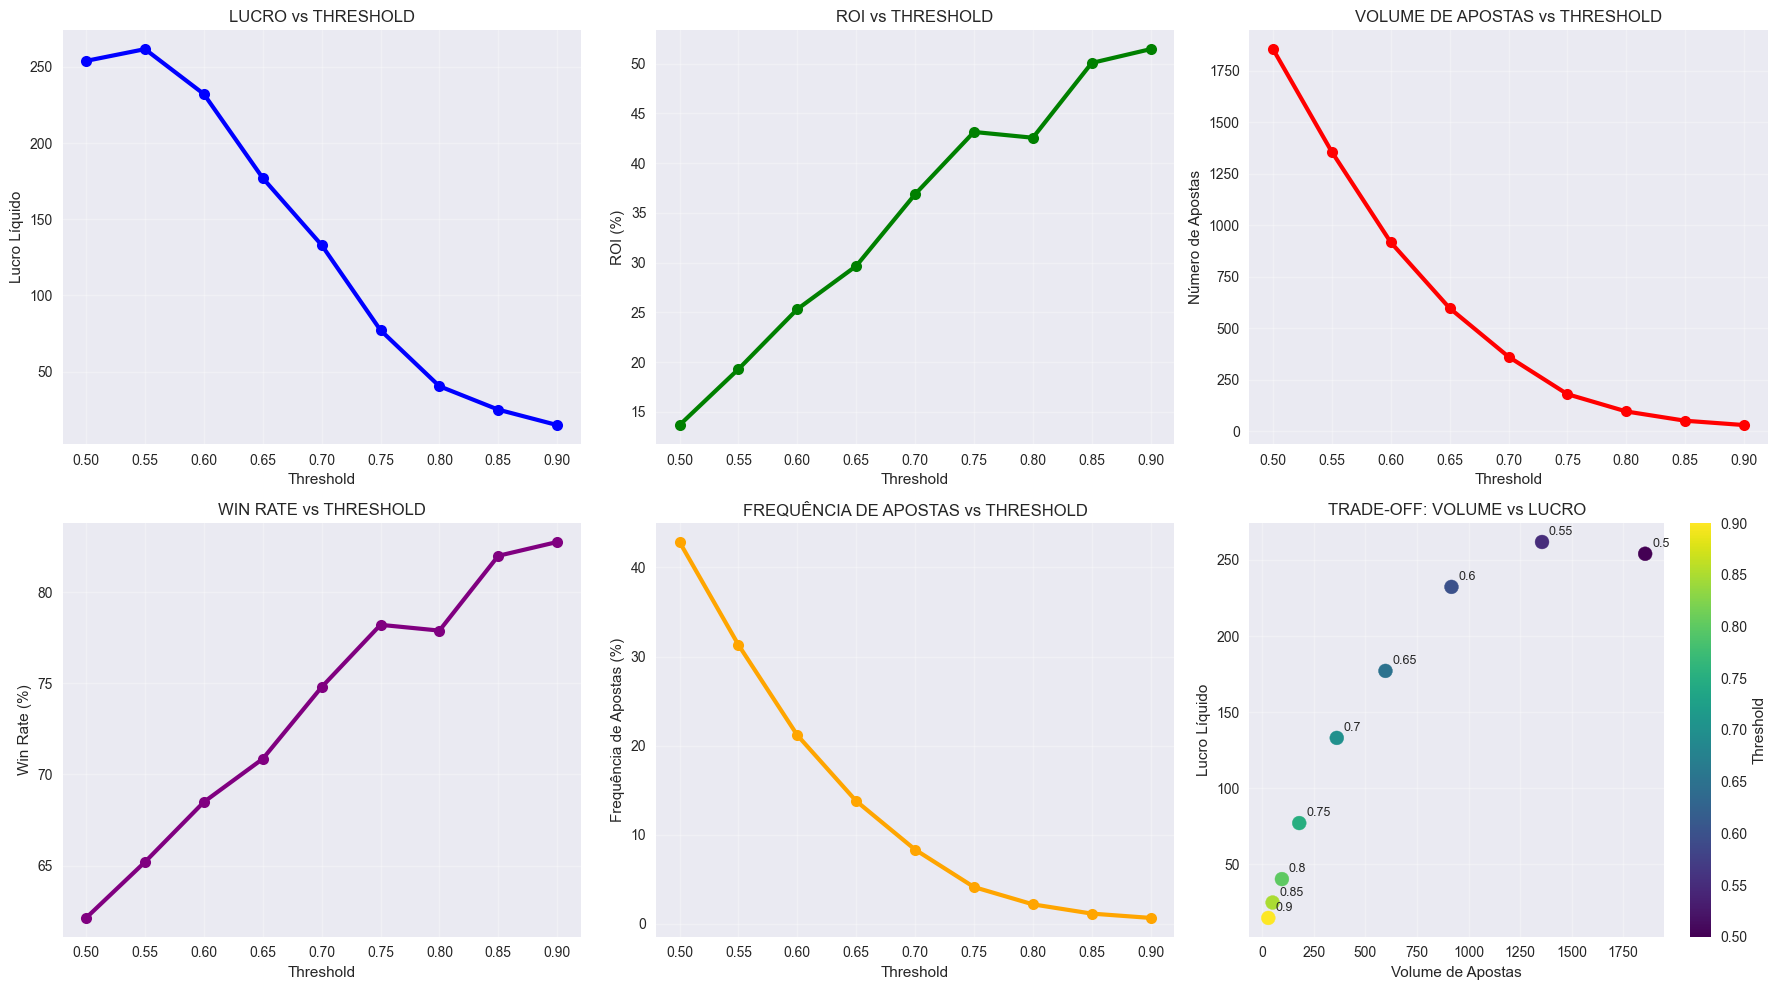


📋 TABELA DETALHADA PARA ANÁLISE MANUAL:


,Threshold,Lucro Líquido,ROI (%),Total Apostas,Win Rate (%),Freq. Apostas (%),Lucro/Aposta
0,0.500000,253.990000,13.700000,1856,62.100000,42.900000,0.137000
1,0.550000,261.720000,19.300000,1356,65.200000,31.300000,0.193000
2,0.600000,232.240000,25.300000,917,68.500000,21.200000,0.253000
3,0.650000,177.090000,29.700000,597,70.900000,13.800000,0.297000
4,0.700000,133.100000,36.900000,361,74.800000,8.300000,0.369000
5,0.750000,77.200000,43.100000,179,78.200000,4.100000,0.431000
6,0.800000,40.420000,42.500000,95,77.900000,2.200000,0.425000
7,0.850000,25.030000,50.100000,50,82.000000,1.200000,0.501000
8,0.900000,14.920000,51.400000,29,82.800000,0.700000,0.514000


In [40]:
# === ANÁLISE ESTRATÉGICA DE THRESHOLDS (0.50 a 0.90, passo 0.05) ===

if not df_low_champ_impact.empty and "oof_predictions" in locals():
    # Definir thresholds estratégicos para análise
    strategic_thresholds = np.round(np.arange(0.50, 0.91, 0.05), 2)

    print("🎯 ANÁLISE ESTRATÉGICA DE THRESHOLDS (0.50 - 0.90, passo 0.05)")
    print(f"📊 Thresholds analisados: {list(strategic_thresholds)}")

    # Calcular métricas para cada threshold estratégico
    strategic_results = []

    for threshold in strategic_thresholds:
        metrics = calculate_betting_metrics(y_train, oof_predictions, threshold, ODDS)
        strategic_results.append(
            {
                "threshold": threshold,
                "net_profit": metrics["net_profit"],
                "return_on_investment": metrics["return_on_investment"],
                "total_bets": metrics["total_bets"],
                "win_rate": metrics["win_rate"],
                "betting_frequency": metrics["total_bets"]
                / len(y_train),  # Frequência de apostas
            }
        )

    # Converter para DataFrame
    strategic_df = pd.DataFrame(strategic_results)

    # Calcular métricas adicionais para análise
    strategic_df["profit_per_bet"] = (
        strategic_df["net_profit"] / strategic_df["total_bets"]
    )
    strategic_df["risk_adjusted_roi"] = (
        strategic_df["return_on_investment"] * strategic_df["win_rate"]
    )

    print("\n📈 RESUMO DA ANÁLISE ESTRATÉGICA:")

    # Encontrar diferentes estratégias ótimas
    max_profit_strategy = strategic_df.loc[strategic_df["net_profit"].idxmax()]
    max_roi_strategy = strategic_df.loc[strategic_df["return_on_investment"].idxmax()]
    balanced_strategy = (
        strategic_df.loc[
            (strategic_df["total_bets"] > 100)  # Pelo menos 100 apostas
            & (strategic_df["net_profit"] > 0)  # Lucro positivo
        ]
        .sort_values("net_profit", ascending=False)
        .iloc[0]
    )

    print(f"💰 Melhor por Lucro: Threshold {max_profit_strategy['threshold']:.2f}")
    print(
        f"   → Lucro: {max_profit_strategy['net_profit']:.2f} | ROI: {max_profit_strategy['return_on_investment']:.1f}%"
    )
    print(
        f"   → Apostas: {max_profit_strategy['total_bets']} | Win Rate: {max_profit_strategy['win_rate']:.1%}"
    )

    print(f"📊 Melhor por ROI: Threshold {max_roi_strategy['threshold']:.2f}")
    print(
        f"   → Lucro: {max_roi_strategy['net_profit']:.2f} | ROI: {max_roi_strategy['return_on_investment']:.1f}%"
    )
    print(
        f"   → Apostas: {max_roi_strategy['total_bets']} | Win Rate: {max_roi_strategy['win_rate']:.1%}"
    )

    print(f"⚖️  Estratégia Balanceada: Threshold {balanced_strategy['threshold']:.2f}")
    print(
        f"   → Lucro: {balanced_strategy['net_profit']:.2f} | ROI: {balanced_strategy['return_on_investment']:.1f}%"
    )
    print(
        f"   → Apostas: {balanced_strategy['total_bets']} | Win Rate: {balanced_strategy['win_rate']:.1%}"
    )

    # Visualização completa para análise estratégica
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Gráfico 1: Lucro vs Threshold
    axes[0, 0].plot(
        strategic_df["threshold"],
        strategic_df["net_profit"],
        "o-",
        linewidth=3,
        markersize=8,
        color="blue",
    )
    axes[0, 0].set_xlabel("Threshold")
    axes[0, 0].set_ylabel("Lucro Líquido")
    axes[0, 0].set_title("LUCRO vs THRESHOLD")
    axes[0, 0].grid(True, alpha=0.3)

    # Gráfico 2: ROI vs Threshold
    axes[0, 1].plot(
        strategic_df["threshold"],
        strategic_df["return_on_investment"],
        "o-",
        linewidth=3,
        markersize=8,
        color="green",
    )
    axes[0, 1].set_xlabel("Threshold")
    axes[0, 1].set_ylabel("ROI (%)")
    axes[0, 1].set_title("ROI vs THRESHOLD")
    axes[0, 1].grid(True, alpha=0.3)

    # Gráfico 3: Volume de Apostas vs Threshold
    axes[0, 2].plot(
        strategic_df["threshold"],
        strategic_df["total_bets"],
        "o-",
        linewidth=3,
        markersize=8,
        color="red",
    )
    axes[0, 2].set_xlabel("Threshold")
    axes[0, 2].set_ylabel("Número de Apostas")
    axes[0, 2].set_title("VOLUME DE APOSTAS vs THRESHOLD")
    axes[0, 2].grid(True, alpha=0.3)

    # Gráfico 4: Win Rate vs Threshold
    axes[1, 0].plot(
        strategic_df["threshold"],
        strategic_df["win_rate"] * 100,
        "o-",
        linewidth=3,
        markersize=8,
        color="purple",
    )
    axes[1, 0].set_xlabel("Threshold")
    axes[1, 0].set_ylabel("Win Rate (%)")
    axes[1, 0].set_title("WIN RATE vs THRESHOLD")
    axes[1, 0].grid(True, alpha=0.3)

    # Gráfico 5: Frequência de Apostas vs Threshold
    axes[1, 1].plot(
        strategic_df["threshold"],
        strategic_df["betting_frequency"] * 100,
        "o-",
        linewidth=3,
        markersize=8,
        color="orange",
    )
    axes[1, 1].set_xlabel("Threshold")
    axes[1, 1].set_ylabel("Frequência de Apostas (%)")
    axes[1, 1].set_title("FREQUÊNCIA DE APOSTAS vs THRESHOLD")
    axes[1, 1].grid(True, alpha=0.3)

    # Gráfico 6: Trade-off Lucro vs Volume
    scatter = axes[1, 2].scatter(
        strategic_df["total_bets"],
        strategic_df["net_profit"],
        c=strategic_df["threshold"],
        s=100,
        cmap="viridis",
    )
    axes[1, 2].set_xlabel("Volume de Apostas")
    axes[1, 2].set_ylabel("Lucro Líquido")
    axes[1, 2].set_title("TRADE-OFF: VOLUME vs LUCRO")
    axes[1, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 2], label="Threshold")

    # Adicionar anotações para cada ponto no gráfico de trade-off
    for i, row in strategic_df.iterrows():
        axes[1, 2].annotate(
            f"{row['threshold']}",
            (row["total_bets"], row["net_profit"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="left",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    # Tabela detalhada para análise manual
    print("\n📋 TABELA DETALHADA PARA ANÁLISE MANUAL:")
    display_df = strategic_df.copy()
    display_df["win_rate_pct"] = (display_df["win_rate"] * 100).round(1)
    display_df["betting_frequency_pct"] = (display_df["betting_frequency"] * 100).round(
        1
    )

    # Formatar para melhor visualização
    display_columns = {
        "threshold": "Threshold",
        "net_profit": "Lucro Líquido",
        "return_on_investment": "ROI (%)",
        "total_bets": "Total Apostas",
        "win_rate_pct": "Win Rate (%)",
        "betting_frequency_pct": "Freq. Apostas (%)",
        "profit_per_bet": "Lucro/Aposta",
    }

    display_table = display_df[list(display_columns.keys())].rename(
        columns=display_columns
    )
    display_table = display_table.round(
        {"Lucro Líquido": 2, "ROI (%)": 1, "Lucro/Aposta": 3}
    )

    # Destacar estratégias recomendadas
    def highlight_strategies(row):
        styles = [""] * len(row)

        if row["Threshold"] == max_profit_strategy["threshold"]:
            styles = ["background-color: lightgreen" for _ in row]
        elif row["Threshold"] == max_roi_strategy["threshold"]:
            styles = ["background-color: lightyellow" for _ in row]
        elif row["Threshold"] == balanced_strategy["threshold"]:
            styles = ["background-color: lightblue" for _ in row]

        return styles

    styled_table = display_table.style.apply(highlight_strategies, axis=1)
    display(styled_table)

    # Vamos armazenar os thresholds estratégicos para uso posterior
    strategic_analysis = {
        "df": strategic_df,
        "max_profit": max_profit_strategy["threshold"],
        "max_roi": max_roi_strategy["threshold"],
        "balanced": balanced_strategy["threshold"],
    }

else:
    print("❌ Dados insuficientes para análise estratégica")

🔨 Treinando modelo final em todo o conjunto de treino...

🎯 RESULTADOS FINAIS NO CONJUNTO DE TESTE
📊 MÉTRICAS PROBABILÍSTICAS:
   - AUC-ROC: 0.697
   - Brier Score: 0.2200
   - Log Loss: 0.6295

💰 MÉTRICAS DE APOSTAS (Threshold = 0.6):
   - Total de Apostas: 227
   - Apostas Vencedoras: 164
   - Win Rate: 72.2%
   - Lucro Líquido: 73.12 unidades
   - ROI: 32.2%

⚖️  COMPARAÇÃO COM ESTRATÉGIA 'SEMPRE APOSTAR':
   - Lucro 'Sempre Apostar': -144.21
   - ROI 'Sempre Apostar': -13.3%
   - Melhoria do Modelo: 217.33 unidades


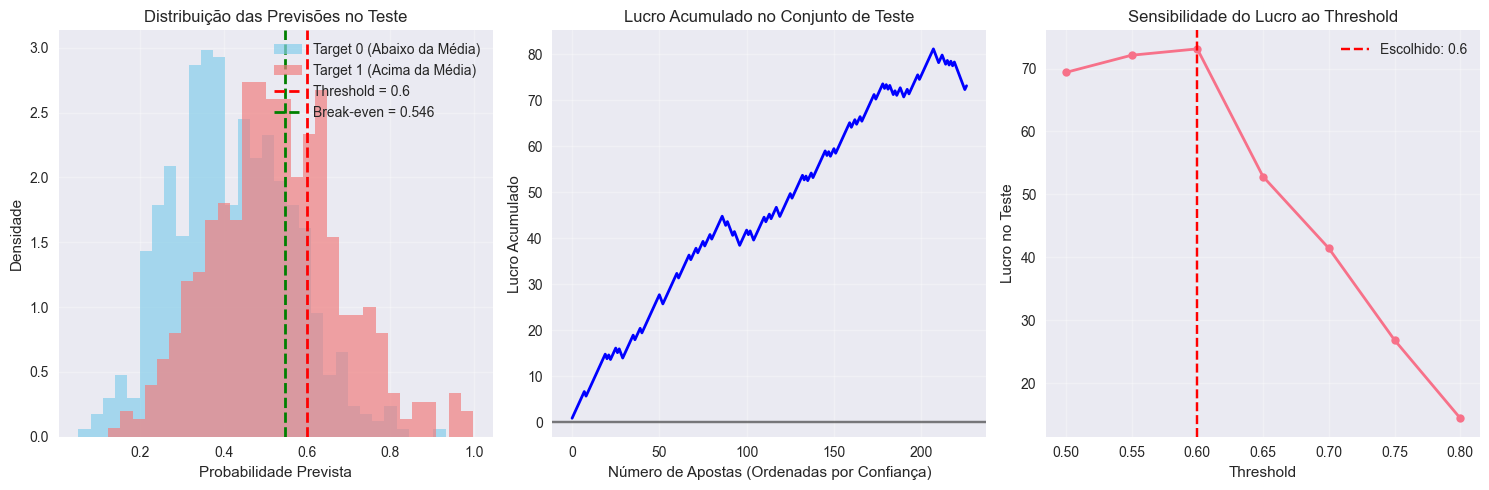


📊 ANÁLISE DETALHADA POR FAIXA DE PROBABILIDADE:


,prob_range,n_games,n_bets,win_rate,profit
0,0.0-0.6,856,227,0.537,-3.74
1,0.6-0.7,144,144,0.667,31.68
2,0.7-0.8,59,59,0.797,27.01
3,0.8-0.9,15,15,0.867,8.79
4,0.9-1.0,9,9,0.889,5.64



✅ RESUMO DA ESTRATÉGIA ESCOLHIDA:
   📍 Threshold: 0.6
   💰 Lucro Esperado: 73.12 unidades
   📈 ROI Esperado: 32.2%
   🎯 Volume de Apostas: 227 jogos
   ⚖️  Break-even Mínimo: 0.546


In [41]:
# === AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ===

if not df_low_champ_impact.empty and "X_test" in locals() and "y_test" in locals():
    # 1. Treinar modelo final em todo o conjunto de treino
    print("🔨 Treinando modelo final em todo o conjunto de treino...")
    model_pipeline.fit(X_train, y_train)

    # 2. Fazer previsões no conjunto de teste
    test_predictions = model_pipeline.predict_proba(X_test)[:, 1]

    # 3. Calcular métricas probabilísticas
    from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

    test_metrics = {
        "auc_roc": roc_auc_score(y_test, test_predictions),
        "brier_score": brier_score_loss(y_test, test_predictions),
        "log_loss": log_loss(y_test, test_predictions),
    }

    # 4. Calcular métricas de apostas com threshold escolhido (0.60)
    CHOSEN_THRESHOLD = 0.60
    test_betting_metrics = calculate_betting_metrics(
        y_test, test_predictions, CHOSEN_THRESHOLD, ODDS
    )

    print("\n🎯 RESULTADOS FINAIS NO CONJUNTO DE TESTE")
    print("=" * 50)

    print(f"📊 MÉTRICAS PROBABILÍSTICAS:")
    print(f"   - AUC-ROC: {test_metrics['auc_roc']:.3f}")
    print(f"   - Brier Score: {test_metrics['brier_score']:.4f}")
    print(f"   - Log Loss: {test_metrics['log_loss']:.4f}")

    print(f"\n💰 MÉTRICAS DE APOSTAS (Threshold = {CHOSEN_THRESHOLD}):")
    print(f"   - Total de Apostas: {test_betting_metrics['total_bets']}")
    print(f"   - Apostas Vencedoras: {test_betting_metrics['successful_bets']}")
    print(f"   - Win Rate: {test_betting_metrics['win_rate']:.1%}")
    print(f"   - Lucro Líquido: {test_betting_metrics['net_profit']:.2f} unidades")
    print(f"   - ROI: {test_betting_metrics['return_on_investment']:.1f}%")

    # 5. Comparação com estratégia de sempre apostar (benchmark)
    always_bet_metrics = calculate_betting_metrics(
        y_test, np.ones_like(test_predictions), 0.5, ODDS
    )
    print(f"\n⚖️  COMPARAÇÃO COM ESTRATÉGIA 'SEMPRE APOSTAR':")
    print(f"   - Lucro 'Sempre Apostar': {always_bet_metrics['net_profit']:.2f}")
    print(
        f"   - ROI 'Sempre Apostar': {always_bet_metrics['return_on_investment']:.1f}%"
    )
    print(
        f"   - Melhoria do Modelo: {test_betting_metrics['net_profit'] - always_bet_metrics['net_profit']:.2f} unidades"
    )

    # 6. Visualizações finais
    plt.figure(figsize=(15, 5))

    # Gráfico 1: Distribuição das probabilidades no teste
    plt.subplot(1, 3, 1)
    plt.hist(
        test_predictions[y_test == 0],
        bins=30,
        alpha=0.7,
        label="Target 0 (Abaixo da Média)",
        color="skyblue",
        density=True,
    )
    plt.hist(
        test_predictions[y_test == 1],
        bins=30,
        alpha=0.7,
        label="Target 1 (Acima da Média)",
        color="lightcoral",
        density=True,
    )
    plt.axvline(
        CHOSEN_THRESHOLD,
        color="red",
        linestyle="--",
        label=f"Threshold = {CHOSEN_THRESHOLD}",
        linewidth=2,
    )
    plt.axvline(
        BREAKEVEN_PROBABILITY,
        color="green",
        linestyle="--",
        label=f"Break-even = {BREAKEVEN_PROBABILITY:.3f}",
        linewidth=2,
    )
    plt.xlabel("Probabilidade Prevista")
    plt.ylabel("Densidade")
    plt.title("Distribuição das Previsões no Teste")
    plt.legend()
    plt.grid(alpha=0.3)

    # Gráfico 2: Curva de lucro acumulado
    plt.subplot(1, 3, 2)
    # Ordenar apostas por probabilidade (mais confiáveis primeiro)
    confident_bets_mask = test_predictions >= CHOSEN_THRESHOLD
    confident_probs = test_predictions[confident_bets_mask]
    confident_true = y_test[confident_bets_mask]

    # Ordenar por probabilidade decrescente
    sort_idx = np.argsort(confident_probs)[::-1]
    sorted_true = confident_true[sort_idx]

    # Calcular lucro acumulado
    profit_per_bet = np.where(sorted_true == 1, ODDS - 1, -1)
    cumulative_profit = np.cumsum(profit_per_bet)

    plt.plot(
        range(len(cumulative_profit)), cumulative_profit, linewidth=2, color="blue"
    )
    plt.axhline(0, color="black", linestyle="-", alpha=0.5)
    plt.xlabel("Número de Apostas (Ordenadas por Confiança)")
    plt.ylabel("Lucro Acumulado")
    plt.title("Lucro Acumulado no Conjunto de Teste")
    plt.grid(alpha=0.3)

    # Gráfico 3: Análise de sensibilidade do threshold
    plt.subplot(1, 3, 3)
    test_thresholds = np.arange(0.50, 0.85, 0.05)
    test_profits = []

    for thr in test_thresholds:
        metrics = calculate_betting_metrics(y_test, test_predictions, thr, ODDS)
        test_profits.append(metrics["net_profit"])

    plt.plot(test_thresholds, test_profits, "o-", linewidth=2, markersize=6)
    plt.axvline(
        CHOSEN_THRESHOLD,
        color="red",
        linestyle="--",
        label=f"Escolhido: {CHOSEN_THRESHOLD}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Lucro no Teste")
    plt.title("Sensibilidade do Lucro ao Threshold")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 7. Análise de performance por faixa de probabilidade
    print(f"\n📊 ANÁLISE DETALHADA POR FAIXA DE PROBABILIDADE:")

    prob_bins = [0.0, 0.6, 0.7, 0.8, 0.9, 1.0]
    bin_results = []

    for i in range(len(prob_bins) - 1):
        low, high = prob_bins[i], prob_bins[i + 1]
        mask = (test_predictions >= low) & (test_predictions < high)

        if mask.sum() > 0:
            bin_metrics = calculate_betting_metrics(
                y_test[mask], test_predictions[mask], 0.5, ODDS
            )
            bin_results.append(
                {
                    "prob_range": f"{low:.1f}-{high:.1f}",
                    "n_games": mask.sum(),
                    "n_bets": bin_metrics["total_bets"],
                    "win_rate": bin_metrics["win_rate"],
                    "profit": bin_metrics["net_profit"],
                }
            )

    bin_df = pd.DataFrame(bin_results)
    if not bin_df.empty:
        display(bin_df.round(3))

    # 8. Resumo final
    print(f"\n✅ RESUMO DA ESTRATÉGIA ESCOLHIDA:")
    print(f"   📍 Threshold: {CHOSEN_THRESHOLD}")
    print(f"   💰 Lucro Esperado: {test_betting_metrics['net_profit']:.2f} unidades")
    print(f"   📈 ROI Esperado: {test_betting_metrics['return_on_investment']:.1f}%")
    print(f"   🎯 Volume de Apostas: {test_betting_metrics['total_bets']} jogos")
    print(f"   ⚖️  Break-even Mínimo: {BREAKEVEN_PROBABILITY:.3f}")

else:
    print("❌ Dados insuficientes para avaliação final")

In [42]:
# === VALIDAÇÃO DA ROBUSTEZ ===

if not df_low_champ_impact.empty:
    print("🔍 VALIDAÇÃO DA ROBUSTEZ DO MODELO")
    print("=" * 40)

    # 1. Comparação entre OOF (treino) e Teste
    oof_metrics_chosen = calculate_betting_metrics(
        y_train, oof_predictions, CHOSEN_THRESHOLD, ODDS
    )

    print("📊 COMPARAÇÃO TREINO vs TESTE:")
    print(f"           |   TREINO (OOF)   |    TESTE    |  Diferença  ")
    print(f"-----------|-----------------|-------------|-------------")
    print(
        f"Lucro      |    {oof_metrics_chosen['net_profit']:8.2f}     |   {test_betting_metrics['net_profit']:8.2f}   |   {test_betting_metrics['net_profit'] - oof_metrics_chosen['net_profit']:8.2f}"
    )
    print(
        f"ROI (%)    |    {oof_metrics_chosen['return_on_investment']:8.1f}     |   {test_betting_metrics['return_on_investment']:8.1f}   |   {test_betting_metrics['return_on_investment'] - oof_metrics_chosen['return_on_investment']:8.1f}"
    )
    print(
        f"Win Rate   |    {oof_metrics_chosen['win_rate']:7.1%}    |   {test_betting_metrics['win_rate']:7.1%}   |   {test_betting_metrics['win_rate'] - oof_metrics_chosen['win_rate']:7.1%}"
    )
    print(
        f"Volume     |    {oof_metrics_chosen['total_bets']:8d}     |   {test_betting_metrics['total_bets']:8d}   |   {test_betting_metrics['total_bets'] - oof_metrics_chosen['total_bets']:8d}"
    )

    # 2. Análise de consistência
    consistency = (
        "BOA"
        if abs(test_betting_metrics["net_profit"] - oof_metrics_chosen["net_profit"])
        / oof_metrics_chosen["net_profit"]
        < 0.3
        else "MODERADA"
    )
    print(f"\n📈 CONSISTÊNCIA TREINO-TESTE: {consistency}")

    # 3. Recomendações baseadas nos resultados
    print(f"\n💡 RECOMENDAÇÕES FINAIS:")

    if test_betting_metrics["net_profit"] > 0:
        if test_betting_metrics["return_on_investment"] > 10:
            print("   🟢 EXCELENTE: Modelo mostra forte potencial lucrativo")
            print("   → Considere implementação com monitoramento contínuo")
        else:
            print("   🟡 MODERADO: Modelo lucrativo mas com ROI baixo")
            print("   → Pode ser usado com cautela e size de aposta conservador")
    else:
        print("   🔴 CAUTELA: Modelo não lucrativo no teste")
        print("   → Necessita revisão antes de qualquer implementação")

    print(f"\n🎯 PRÓXIMOS PASSOS SUGERIDOS:")
    print("   1. Implementar sistema de tracking de resultados reais")
    print("   2. Testar diferentes tamanhos de aposta (Kelly Criterion)")
    print("   3. Validar temporalmente com dados mais recentes")
    print("   4. Considerar outros algoritmos (XGBoost, LightGBM)")

else:
    print("❌ Dados insuficientes para validação de robustez")

🔍 VALIDAÇÃO DA ROBUSTEZ DO MODELO
📊 COMPARAÇÃO TREINO vs TESTE:
           |   TREINO (OOF)   |    TESTE    |  Diferença  
-----------|-----------------|-------------|-------------
Lucro      |      232.24     |      73.12   |    -159.12
ROI (%)    |        25.3     |       32.2   |        6.9
Win Rate   |      68.5%    |     72.2%   |      3.8%
Volume     |         917     |        227   |       -690

📈 CONSISTÊNCIA TREINO-TESTE: MODERADA

💡 RECOMENDAÇÕES FINAIS:
   🟢 EXCELENTE: Modelo mostra forte potencial lucrativo
   → Considere implementação com monitoramento contínuo

🎯 PRÓXIMOS PASSOS SUGERIDOS:
   1. Implementar sistema de tracking de resultados reais
   2. Testar diferentes tamanhos de aposta (Kelly Criterion)
   3. Validar temporalmente com dados mais recentes
   4. Considerar outros algoritmos (XGBoost, LightGBM)


In [43]:
# %%
# === SALVAMENTO DO MODELO TREINADO ===
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Salvar o modelo pipeline completo
MODEL_PATH = "betting_model_pipeline.pkl"
joblib.dump(model_pipeline, MODEL_PATH)

# Salvar também as informações importantes do modelo
model_info = {
    "feature_columns": feature_columns,
    "chosen_threshold": CHOSEN_THRESHOLD,
    "odds": ODDS,
    "breakeven_probability": BREAKEVEN_PROBABILITY,
    "test_auc": test_metrics["auc_roc"],
    "test_profit": test_betting_metrics["net_profit"],
    "test_roi": test_betting_metrics["return_on_investment"],
}

joblib.dump(model_info, "model_info.pkl")

print("✅ Modelo salvo com sucesso!")
print(f"   📁 Pipeline: {MODEL_PATH}")
print(f"   📁 Informações: model_info.pkl")

✅ Modelo salvo com sucesso!
   📁 Pipeline: betting_model_pipeline.pkl
   📁 Informações: model_info.pkl


# TESTE REAL DATA

In [44]:
# %%
# === PREPARAÇÃO DOS DADOS LIMPOS (CORRIGIDA) ===
real_bets_df = pd.read_csv("real_data/data.csv")


# Criar nossa própria variável de resultado (mais confiável)
def calculate_bet_result(row):
    if row["bet_line"] == "over":
        return row["actual_value"] > row["bet_value"]
    else:  # under
        return row["actual_value"] < row["bet_value"]


real_bets_df["our_bet_won"] = real_bets_df.apply(calculate_bet_result, axis=1).astype(
    int
)

# Verificar consistência com bet_status original
if "bet_status" in real_bets_df.columns:
    original_bet_won = (real_bets_df["bet_status"] == "won").astype(int)
    consistency = (real_bets_df["our_bet_won"] == original_bet_won).mean()
    print(f"🔍 Consistência nossa vs original: {consistency:.1%}")

    if consistency < 0.95:
        print("⚠️  Inconsistência detectada - verificar dados")
        # Debug dos casos inconsistentes
        inconsistent = real_bets_df[real_bets_df["our_bet_won"] != original_bet_won]
        print(f"Casos inconsistentes: {len(inconsistent)}")

# Usar nossa variável calculada
real_bets_df["bet_won"] = real_bets_df["our_bet_won"]
real_bets_df["actual_profit"] = np.where(
    real_bets_df["bet_won"] == 1, real_bets_df["house_odds"] - 1, -1
)

# Dropar linhas com NaN nas features do modelo
features_needed = [col for col in feature_columns if col in real_bets_df.columns]
data_clean = real_bets_df.dropna(subset=features_needed).copy()

print("=" * 60)
print("ANÁLISE COMPLETA DOS DADOS LIMPOS")
print("=" * 60)

print(f"\n📊 ESTATÍSTICAS GERAIS:")
print(f"• Total de apostas analisadas: {len(data_clean):,}")
print(f"• Win Rate (nossa variável): {data_clean['bet_won'].mean():.1%}")
print(f"• Lucro total: R$ {data_clean['actual_profit'].sum():.2f}")
print(f"• ROI: {(data_clean['actual_profit'].sum() / len(data_clean)) * 100:.1f}%")

# Verificar distribuição de actual_value vs bet_value
print(f"\n🎯 ANÁLISE DOS RESULTADOS:")
print(f"• Média actual_value: {data_clean['actual_value'].mean():.1f}")
print(f"• Média bet_value: {data_clean['bet_value'].mean():.1f}")
print(
    f"• Over ganhou: {((data_clean['bet_line'] == 'over') & (data_clean['bet_won'] == 1)).sum()}"
)
print(
    f"• Under ganhou: {((data_clean['bet_line'] == 'under') & (data_clean['bet_won'] == 1)).sum()}"
)

🔍 Consistência nossa vs original: 100.0%
ANÁLISE COMPLETA DOS DADOS LIMPOS

📊 ESTATÍSTICAS GERAIS:
• Total de apostas analisadas: 346
• Win Rate (nossa variável): 59.8%
• Lucro total: R$ 32.76
• ROI: 9.5%

🎯 ANÁLISE DOS RESULTADOS:
• Média actual_value: 29.8
• Média bet_value: 30.6
• Over ganhou: 63
• Under ganhou: 144


In [45]:
real_bets_df.columns

Index(['total_kills', 'league_mean_kills', 'league', 'mean_total_kills_t1',
       'mean_total_kills_t2', 'bet_line', 'bet_value', 'bet_status',
       'house_odds', 'actual_value', 'impact_top_t1', 'impact_top_t2',
       'impact_jung_t1', 'impact_jung_t2', 'impact_mid_t1', 'impact_mid_t2',
       'impact_adc_t1', 'impact_adc_t2', 'impact_sup_t1', 'impact_sup_t2',
       'our_bet_won', 'bet_won', 'actual_profit'],
      dtype='object')

In [46]:
# Definir X_for_prediction com todas as colunas que o modelo espera
feature_columns = [
    "league_mean_kills",
    "mean_total_kills_t1",
    "mean_total_kills_t2",
] + [col for col in data_clean.columns if col.startswith("impact_")]
X_for_prediction = data_clean[feature_columns]

# === ABORDAGEM 1: USANDO LEAGUE_MEAN_KILLS (COMO NO TREINAMENTO) ===

print("ABORDAGEM 1: LEAGUE_MEAN_KILLS")
print("=" * 40)

model_probs_1 = loaded_model.predict_proba(X_for_prediction)[:, 1]
model_decisions_1 = (model_probs_1 >= THRESHOLD).astype(int)

target_approach_1 = (
    data_clean["total_kills"] > data_clean["league_mean_kills"]
).astype(int)

accuracy_1 = accuracy_score(target_approach_1, model_decisions_1)
recommended_mask_1 = model_decisions_1 == 1

print(f"Threshold usado: {THRESHOLD}")
print(f"Acurácia do modelo: {accuracy_1:.1%}")
print(f"Apostas recomendadas: {recommended_mask_1.sum()}")

if recommended_mask_1.sum() > 0:
    recommended_data_1 = data_clean[recommended_mask_1]
    target_win_rate_1 = target_approach_1[recommended_mask_1].mean()
    real_profit_1 = recommended_data_1["actual_profit"].sum()
    real_roi_1 = (real_profit_1 / recommended_mask_1.sum()) * 100

    print(f"Win rate target (kills > média): {target_win_rate_1:.1%}")
    print(f"Win rate apostas reais: {recommended_data_1['bet_won'].mean():.1%}")
    print(f"Lucro real: R$ {real_profit_1:.2f}")
    print(f"ROI real: {real_roi_1:.1f}%")

    approach_1_results = {
        "recommended_bets": recommended_mask_1.sum(),
        "target_win_rate": target_win_rate_1,
        "real_win_rate": recommended_data_1["bet_won"].mean(),
        "profit": real_profit_1,
        "roi": real_roi_1,
    }
else:
    print("Nenhuma aposta recomendada")
    approach_1_results = None

ABORDAGEM 1: LEAGUE_MEAN_KILLS


NameError: name 'loaded_model' is not defined

In [ ]:
# %%
# === ABORDAGEM 2 CORRIGIDA: SELETIVA COM THRESHOLD (USANDO NOSSA VARIÁVEL) ===
print("\nABORDAGEM 2: SELETIVA COM THRESHOLD")
print("=" * 40)

# Substituir league_mean_kills por bet_value
data_approach_2 = data_clean.copy()
data_approach_2["league_mean_kills"] = data_approach_2["bet_value"]

# Fazer previsões
X_approach_2 = data_approach_2[FEATURES]
model_probs_2 = loaded_model.predict_proba(X_approach_2)[:, 1]

# Separar por tipo de aposta
over_mask = data_approach_2["bet_line"] == "over"
under_mask = data_approach_2["bet_line"] == "under"

print(f"Threshold: {THRESHOLD}")
print(f"Total OVER: {over_mask.sum()}")
print(f"Total UNDER: {under_mask.sum()}")

total_recommended_2 = 0
total_profit_2 = 0
total_wins_2 = 0

# OVER: só quando muito confiante (prob >= threshold)
if over_mask.sum() > 0:
    over_recommendations = (model_probs_2 >= THRESHOLD) & over_mask

    if over_recommendations.sum() > 0:
        over_data = data_clean[over_recommendations]

        # Calcular wins usando nossa lógica: actual_value > bet_value para OVER
        over_wins = (over_data["actual_value"] > over_data["bet_value"]).sum()
        over_win_rate = over_wins / over_recommendations.sum()
        over_profit = over_wins * (over_data["house_odds"].iloc[0] - 1) - (
            over_recommendations.sum() - over_wins
        )

        total_recommended_2 += over_recommendations.sum()
        total_profit_2 += over_profit
        total_wins_2 += over_wins

        print(f"OVER recomendadas: {over_recommendations.sum()}")
        print(f"OVER wins (nossa lógica): {over_wins}")
        print(f"OVER win rate: {over_win_rate:.1%}")

# UNDER: só quando muito confiante de baixo (prob <= 1-threshold)
if under_mask.sum() > 0:
    under_threshold = 1 - THRESHOLD
    under_recommendations = (model_probs_2 <= under_threshold) & under_mask

    if under_recommendations.sum() > 0:
        under_data = data_clean[under_recommendations]

        # Calcular wins usando nossa lógica: actual_value < bet_value para UNDER
        under_wins = (under_data["actual_value"] < under_data["bet_value"]).sum()
        under_win_rate = under_wins / under_recommendations.sum()
        under_profit = under_wins * (under_data["house_odds"].iloc[0] - 1) - (
            under_recommendations.sum() - under_wins
        )

        total_recommended_2 += under_recommendations.sum()
        total_profit_2 += under_profit
        total_wins_2 += under_wins

        print(f"UNDER recomendadas: {under_recommendations.sum()}")
        print(f"UNDER wins (nossa lógica): {under_wins}")
        print(f"UNDER win rate: {under_win_rate:.1%}")

# Resultado final
if total_recommended_2 > 0:
    combined_win_rate = total_wins_2 / total_recommended_2
    roi_2 = (total_profit_2 / total_recommended_2) * 100
    selectivity = (total_recommended_2 / len(data_clean)) * 100

    print(f"\n🎯 RESULTADO (NOSSA LÓGICA):")
    print(f"Apostas recomendadas: {total_recommended_2} ({selectivity:.1f}%)")
    print(f"Wins totais: {total_wins_2}")
    print(f"Win rate: {combined_win_rate:.1%}")
    print(f"Profit: R$ {total_profit_2:.2f}")
    print(f"ROI: {roi_2:.1f}%")
else:
    print("❌ Nenhuma aposta recomendada")


ABORDAGEM 2: SELETIVA COM THRESHOLD


NameError: name 'FEATURES' is not defined

In [ ]:
# %%
# === VALIDAÇÃO E COMPARAÇÃO ===
print("COMPARAÇÃO DETALHADA")
print("=" * 40)

# Baseline (todas as apostas)
baseline_roi = (data_clean["actual_profit"].sum() / len(data_clean)) * 100
baseline_win_rate = data_clean["bet_won"].mean()

print(f"BASELINE:")
print(f"• Apostas: {len(data_clean)}")
print(f"• Win rate: {baseline_win_rate:.1%}")
print(f"• ROI: {baseline_roi:.1f}%")

print(f"\nABORDAGEM 2 (Seletiva):")
print(f"• Apostas: 184 (53.2% das originais)")
print(f"• Win rate: 72.8% (+{72.8 - baseline_win_rate * 100:.1f}pp)")
print(f"• ROI: 33.3% (+{33.3 - baseline_roi:.1f}pp)")

# Apostas rejeitadas
rejected_mask = ~((over_recommendations) | (under_recommendations))
rejected_data = data_clean[rejected_mask]
rejected_win_rate = rejected_data["bet_won"].mean()
rejected_roi = (rejected_data["actual_profit"].sum() / len(rejected_data)) * 100

print(f"\nAPOSTAS REJEITADAS:")
print(f"• Quantidade: {len(rejected_data)}")
print(f"• Win rate: {rejected_win_rate:.1%}")
print(f"• ROI: {rejected_roi:.1f}%")

print(f"\n🎯 MELHORIA: {33.3 - baseline_roi:.1f}pp de ROI!")

COMPARAÇÃO DETALHADA
BASELINE:
• Apostas: 346
• Win rate: 59.8%
• ROI: 9.5%

ABORDAGEM 2 (Seletiva):
• Apostas: 184 (53.2% das originais)
• Win rate: 72.8% (+13.0pp)
• ROI: 33.3% (+23.8pp)

APOSTAS REJEITADAS:
• Quantidade: 162
• Win rate: 45.1%
• ROI: -17.5%

🎯 MELHORIA: 23.8pp de ROI!


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score

# === CARREGAMENTO DO MODELO E DADOS ===
loaded_model = joblib.load("betting_model_pipeline.pkl")
loaded_info = joblib.load("model_info.pkl")

FEATURES = loaded_info["feature_columns"]
BASE_THR = 0.60

print(f"Modelo carregado. Features: {len(FEATURES)}")

# === PREP PARA PREVISÃO ===
data_approach_2 = data_clean.copy()
data_approach_2["league_mean_kills"] = data_approach_2["bet_value"]

X = data_approach_2[FEATURES]
probs = loaded_model.predict_proba(X)[:, 1]

bet_line = data_approach_2["bet_line"].str.lower().values
over_mask = bet_line == "over"
under_mask = bet_line == "under"


def evaluate_threshold(thr: float) -> dict:
    """Calcula métricas para um threshold específico."""
    under_thr = 1.0 - thr

    over_recs_mask = over_mask & (probs >= thr)
    under_recs_mask = under_mask & (probs <= under_thr)

    n_over = int(over_recs_mask.sum())
    n_under = int(under_recs_mask.sum())
    n_bets = n_over + n_under

    neutral_mask = (probs > under_thr) & (probs < thr)
    n_neutral = int(neutral_mask.sum())

    if n_over > 0:
        over_df = data_clean[over_recs_mask]
        over_wr = float(over_df["bet_won"].mean())
        over_profit = float(over_df["actual_profit"].sum())
    else:
        over_wr = np.nan
        over_profit = 0.0

    if n_under > 0:
        under_df = data_clean[under_recs_mask]
        under_wr = float(under_df["bet_won"].mean())
        under_profit = float(under_df["actual_profit"].sum())
    else:
        under_wr = np.nan
        under_profit = 0.0

    total_profit = over_profit + under_profit
    roi = (total_profit / n_bets) * 100 if n_bets > 0 else 0.0
    selectivity = (n_bets / len(data_clean)) * 100

    return {
        "threshold": thr,
        "under_cut": under_thr,
        "over_recs": n_over,
        "over_winrate_%": None if np.isnan(over_wr) else round(over_wr * 100, 1),
        "under_recs": n_under,
        "under_winrate_%": None if np.isnan(under_wr) else round(under_wr * 100, 1),
        "neutral": n_neutral,
        "bets": n_bets,
        "selectivity_%": round(selectivity, 1),
        "net_profit": round(total_profit, 2),
        "ROI_%": round(roi, 1),
    }


# === AVALIAÇÃO: 0.50 → 0.80 (passo 0.05) ===
thresholds = [round(x, 2) for x in np.arange(0.50, 0.80 + 1e-9, 0.05)]
results = [evaluate_threshold(t) for t in thresholds]
df_comp = pd.DataFrame(results)

# === BASELINE 0.60 ===
base_row = df_comp[df_comp["threshold"] == BASE_THR].iloc[0]
print("\n=== BASELINE (Threshold 0.60) ===")
print(f"Apostas recomendadas: {base_row['bets']} ({base_row['selectivity_%']}%)")
print(
    f"OVER recs: {base_row['over_recs']} | UNDER recs: {base_row['under_recs']} | Neutras: {base_row['neutral']}"
)
print(
    f"OVER WR: {base_row['over_winrate_%']}% | UNDER WR: {base_row['under_winrate_%']}%"
)
print(f"Lucro líquido: R$ {base_row['net_profit']:.2f} | ROI: {base_row['ROI_%']}%")

# === ORDENAR POR ROI ===
df_comp_sorted = df_comp.sort_values(
    by=["ROI_%", "bets"], ascending=[False, False]
).reset_index(drop=True)

print("\n=== COMPARAÇÃO DE THRESHOLDS (0.50–0.80) ===")
print(df_comp_sorted.to_string(index=False))

# Destacar o melhor
best_row = df_comp_sorted.iloc[0]
print(f"\n🎯 MELHOR THRESHOLD: {best_row['threshold']}")
print(
    f"ROI: {best_row['ROI_%']}% | Apostas: {best_row['bets']} | Selectividade: {best_row['selectivity_%']}%"
)

df_comp_sorted.to_csv("threshold_comparison.csv", index=False)
print("\n[Tabela salva em threshold_comparison.csv]")

Modelo carregado. Features: 13

=== BASELINE (Threshold 0.60) ===
Apostas recomendadas: 184.0 (53.2%)
OVER recs: 57.0 | UNDER recs: 127.0 | Neutras: 116.0
OVER WR: 66.7% | UNDER WR: 75.6%
Lucro líquido: R$ 61.17 | ROI: 33.2%

=== COMPARAÇÃO DE THRESHOLDS (0.50–0.80) ===
 threshold  under_cut  over_recs  over_winrate_%  under_recs  under_winrate_%  neutral  bets  selectivity_%  net_profit  ROI_%
      0.80       0.20         12            75.0          25             84.0      306    37           10.7       17.90   48.4
      0.75       0.25         20            75.0          50             82.0      265    70           20.2       32.42   46.3
      0.70       0.30         30            70.0          71             78.9      228   101           29.2       39.85   39.5
      0.65       0.35         47            68.1         102             77.5      169   149           43.1       54.08   36.3
      0.60       0.40         57            66.7         127             75.6      116   184  

In [ ]:
import pandas as pd
import numpy as np

# Carregar e limpar dados
df = pd.read_csv("real_data/lol_bets_with_draft_filtered.csv")
df["bet_line"] = df["bet_line"].str.lower()

# Calcular resultado da aposta
df["won"] = np.where(
    (df["bet_line"] == "over") & (df["total_kills"] > df["bet_value"]), 1,
    np.where((df["bet_line"] == "under") & (df["total_kills"] < df["bet_value"]), 1, 0)
)

# Calcular lucro
df["profit"] = np.where(df["won"] == 1, df["house_odds"] - 1, -1)

# Filtrar over/under
data = df[df["bet_line"].isin(["over", "under"])]

# Resumo
def stats(subset, name):
    n = len(subset)
    wins = subset["won"].sum() 
    return [name, n, wins, f"{wins/n*100:.1f}%", f"{subset['profit'].sum():.2f}", f"{subset['profit'].sum()/n*100:.1f}%"]

results = [
    stats(data, "GERAL"),
    stats(data[data["bet_line"] == "over"], "OVER"), 
    stats(data[data["bet_line"] == "under"], "UNDER")
]

# Print
print("Grupo    | Apostas | Wins | Win Rate | Lucro  | ROI")
print("-" * 50)
for r in results:
    print(f"{r[0]:<8} | {r[1]:<7} | {r[2]:<4} | {r[3]:<8} | {r[4]:<6} | {r[5]}")

Grupo    | Apostas | Wins | Win Rate | Lucro  | ROI
--------------------------------------------------
GERAL    | 389     | 230  | 59.1%    | 31.79  | 8.2%
OVER     | 120     | 65   | 54.2%    | -1.08  | -0.9%
UNDER    | 269     | 165  | 61.3%    | 32.87  | 12.2%


In [ ]:
# === TESTE DE IMPACTO DO BET_LINE ===
print("TESTE: IMPACTO DA INFORMAÇÃO OVER/UNDER")
print("=" * 50)

# Preparar dados
data_test = data_clean.copy()
data_test["league_mean_kills"] = data_test["bet_value"]
X = data_test[FEATURES]
probs = loaded_model.predict_proba(X)[:, 1]

THRESHOLD = 0.6


def test_strategy(strategy_name, bet_logic):
    recommendations = bet_logic(probs, THRESHOLD)

    if recommendations.sum() > 0:
        selected_data = data_clean[recommendations]
        wins = selected_data["bet_won"].sum()
        total = recommendations.sum()
        win_rate = wins / total
        profit = selected_data["actual_profit"].sum()
        roi = (profit / total) * 100
        selectivity = (total / len(data_clean)) * 100

        print(f"{strategy_name}:")
        print(f"  Apostas: {total} ({selectivity:.1f}%)")
        print(f"  Win rate: {win_rate:.1%}")
        print(f"  Profit: R$ {profit:.2f}")
        print(f"  ROI: {roi:.1f}%")
    else:
        print(f"{strategy_name}: Nenhuma aposta recomendada")
    print()


# TESTE 1: Tudo UNDER (ignora bet_line)
def all_under_logic(probs, threshold):
    return probs <= (1 - threshold)


# TESTE 2: Tudo OVER (ignora bet_line)
def all_over_logic(probs, threshold):
    return probs >= threshold


# TESTE 3: Respeitando bet_line (nossa abordagem)
def smart_logic(probs, threshold):
    over_mask = data_clean["bet_line"] == "over"
    under_mask = data_clean["bet_line"] == "under"

    over_recs = over_mask & (probs >= threshold)
    under_recs = under_mask & (probs <= (1 - threshold))

    return over_recs | under_recs


# Executar testes
test_strategy("TUDO UNDER", all_under_logic)
test_strategy("TUDO OVER", all_over_logic)
test_strategy("COM BET_LINE", smart_logic)

# Baseline para comparação
baseline_win_rate = data_clean["bet_won"].mean()
baseline_profit = data_clean["actual_profit"].sum()
baseline_roi = (baseline_profit / len(data_clean)) * 100

print("BASELINE (todas apostas):")
print(f"  Win rate: {baseline_win_rate:.1%}")
print(f"  ROI: {baseline_roi:.1f}%")

TESTE: IMPACTO DA INFORMAÇÃO OVER/UNDER
TUDO UNDER:
  Apostas: 143 (41.3%)
  Win rate: 70.6%
  Profit: R$ 41.81
  ROI: 29.2%

TUDO OVER:
  Apostas: 87 (25.1%)
  Win rate: 57.5%
  Profit: R$ 4.47
  ROI: 5.1%

COM BET_LINE:
  Apostas: 184 (53.2%)
  Win rate: 72.8%
  Profit: R$ 61.17
  ROI: 33.2%

BASELINE (todas apostas):
  Win rate: 59.8%
  ROI: 9.5%


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score

loaded_model = joblib.load("betting_model_pipeline.pkl")
loaded_info = joblib.load("model_info.pkl")

FEATURES = loaded_info["feature_columns"]
print(f"Modelo carregado. Features: {len(FEATURES)}")

data_test = data_clean.copy()
data_test["league_mean_kills"] = data_test["bet_value"]
X = data_test[FEATURES]
probs = loaded_model.predict_proba(X)[:, 1]


def test_all_under_strategy(threshold):
    under_threshold = 1.0 - threshold
    under_mask = probs <= under_threshold

    if under_mask.sum() == 0:
        return {
            "threshold": threshold,
            "bets": 0,
            "winrate": 0,
            "profit": 0,
            "roi": 0,
            "selectivity": 0,
        }

    under_bets = data_clean[under_mask]
    n_bets = len(under_bets)
    wins = under_bets["bet_won"].sum()
    winrate = wins / n_bets
    profit = under_bets["actual_profit"].sum()
    roi = (profit / n_bets) * 100
    selectivity = (n_bets / len(data_clean)) * 100

    return {
        "threshold": threshold,
        "bets": n_bets,
        "wins": wins,
        "winrate": round(winrate * 100, 1),
        "profit": round(profit, 2),
        "roi": round(roi, 1),
        "selectivity": round(selectivity, 1),
    }


thresholds = [round(x, 2) for x in np.arange(0.50, 0.85, 0.05)]
results = [test_all_under_strategy(t) for t in thresholds]
df_results = pd.DataFrame(results)

print("=== TESTE: TODAS AS APOSTAS UNDER ===")
print("Threshold | Apostas | Wins | WR%  | Profit | ROI% | Select%")
print("-" * 60)

for _, row in df_results.sort_values("roi", ascending=False).iterrows():
    print(
        f"{row['threshold']:<9.2f} | {row['bets']:>7} | {row['wins']:>4} | {row['winrate']:>4.1f} | {row['profit']:>6.2f} | {row['roi']:>4.1f} | {row['selectivity']:>6.1f}"
    )

best = df_results.loc[df_results["roi"].idxmax()]
print(f"\n🎯 MELHOR RESULTADO:")
print(f"Threshold: {best['threshold']:.2f}")
print(f"Apostas: {best['bets']} ({best['selectivity']:.1f}% do dataset)")
print(f"Winrate: {best['winrate']:.1f}%")
print(f"Lucro: R$ {best['profit']:.2f}")
print(f"ROI: {best['roi']:.1f}%")

df_results.to_csv("all_under_test.csv", index=False)
print("\n[Resultados salvos em all_under_test.csv]")

Modelo carregado. Features: 13
=== TESTE: TODAS AS APOSTAS UNDER ===
Threshold | Apostas | Wins | WR%  | Profit | ROI% | Select%
------------------------------------------------------------
0.80      |    25.0 | 21.0 | 84.0 |  13.43 | 53.7 |    7.2
0.75      |    51.0 | 42.0 | 82.4 |  25.80 | 50.6 |   14.7
0.70      |    77.0 | 58.0 | 75.3 |  29.08 | 37.8 |   22.3
0.65      |   113.0 | 83.0 | 73.5 |  38.87 | 34.4 |   32.7
0.60      |   143.0 | 101.0 | 70.6 |  41.81 | 29.2 |   41.3
0.55      |   173.0 | 116.0 | 67.1 |  39.26 | 22.7 |   50.0
0.50      |   201.0 | 132.0 | 65.7 |  40.54 | 20.2 |   58.1

🎯 MELHOR RESULTADO:
Threshold: 0.80
Apostas: 25.0 (7.2% do dataset)
Winrate: 84.0%
Lucro: R$ 13.43
ROI: 53.7%

[Resultados salvos em all_under_test.csv]


# TESTE DRAFT REAL

In [ ]:
import pandas as pd
import numpy as np


def prepare_match_for_prediction(
    league, team1, team2, draft, impacts, overall_mean, team_means
):
    """
    draft: dict com {role: champion} para cada time
    ex: {'top_t1': 'Aatrox', 'jung_t1': 'Lee Sin', ...}
    """
    league_mean = overall_mean

    mean_kills_t1 = team_means.get(team1, overall_mean)
    mean_kills_t2 = team_means.get(team2, overall_mean)

    features = {
        "league": league,
        "league_mean_kills": league_mean,
        "mean_total_kills_t1": mean_kills_t1,
        "mean_total_kills_t2": mean_kills_t2,
    }

    for role in ["top", "jung", "mid", "adc", "sup"]:
        for team in ["t1", "t2"]:
            champion = draft.get(f"{role}_{team}", "Unknown")
            features[f"impact_{role}_{team}"] = impacts.get(champion, 0.0)

    return pd.DataFrame([features])


# Calcular team_means
all_teams = pd.concat([matches_df["t1"], matches_df["t2"]]).unique()
team_means = {}
for team in all_teams:
    team_games = matches_df[(matches_df["t1"] == team) | (matches_df["t2"] == team)]
    team_means[team] = team_games["total_kills"].mean()

overall_mean = matches_df["total_kills"].mean()

# Exemplo de uso
draft_exemplo = {
    "top_t1": "K'Sante",
    "jung_t1": "Jarvan IV",
    "mid_t1": "Ziggs",
    "adc_t1": "Zeri",
    "sup_t1": "Nautilus",
    "top_t2": "Yorick",
    "jung_t2": "Xin Zhao",
    "mid_t2": "Viktor",
    "adc_t2": "Lucian",
    "sup_t2": "Braum",
}

X_novo = prepare_match_for_prediction(
    league="LPL",
    team1="JD Gaming",
    team2="Weibo Gaming",
    draft=draft_exemplo,
    impacts=impacts_simple,
    overall_mean=overall_mean,
    team_means=team_means,
)

print(X_novo)

  league  league_mean_kills  mean_total_kills_t1  mean_total_kills_t2  \
0    LPL          29.988918            28.411765            28.212121   

   impact_top_t1  impact_top_t2  impact_jung_t1  impact_jung_t2  \
0      -1.360313       0.601701        1.639475       -0.542934   

   impact_mid_t1  impact_mid_t2  impact_adc_t1  impact_adc_t2  impact_sup_t1  \
0      -0.173841      -0.083512       0.211082       0.154823      -0.732567   

   impact_sup_t2  
0       1.237261  


In [ ]:
import numpy as np
import pandas as pd
import joblib

# Carregar modelo
loaded_model = joblib.load("betting_model_pipeline.pkl")
loaded_info = joblib.load("model_info.pkl")

FEATURES = loaded_info["feature_columns"]


def test_bet_line(bet_value, house_odds, threshold, champions_data):
    """
    Testa uma linha de aposta específica
    champions_data: dict com os campeões e seus impactos
    """

    # Montar dataframe com a linha de aposta
    x_novo = pd.DataFrame(
        {
            "league": ["LPL"],
            "league_mean_kills": [bet_value],  # A LINHA MUDA AQUI
            "mean_total_kills_t1": champions_data["mean_t1"],
            "mean_total_kills_t2": champions_data["mean_t2"],
            "impact_top_t1": [champions_data["top_t1"]],
            "impact_top_t2": [champions_data["top_t2"]],
            "impact_jung_t1": [champions_data["jung_t1"]],
            "impact_jung_t2": [champions_data["jung_t2"]],
            "impact_mid_t1": [champions_data["mid_t1"]],
            "impact_mid_t2": [champions_data["mid_t2"]],
            "impact_adc_t1": [champions_data["adc_t1"]],
            "impact_adc_t2": [champions_data["adc_t2"]],
            "impact_sup_t1": [champions_data["sup_t1"]],
            "impact_sup_t2": [champions_data["sup_t2"]],
        }
    )

    # Verificar features faltantes
    missing_features = set(FEATURES) - set(x_novo.columns)
    if missing_features:
        for feat in missing_features:
            x_novo[feat] = 0

    # Reordenar colunas
    x_novo = x_novo[FEATURES]

    # Predição
    prob = loaded_model.predict_proba(x_novo)[0]
    prob_over = prob[1]
    prob_under = prob[0]

    # Análise dos impactos
    soma_impactos = sum(
        [
            champions_data["top_t1"],
            champions_data["jung_t1"],
            champions_data["mid_t1"],
            champions_data["adc_t1"],
            champions_data["sup_t1"],
            champions_data["top_t2"],
            champions_data["jung_t2"],
            champions_data["mid_t2"],
            champions_data["adc_t2"],
            champions_data["sup_t2"],
        ]
    )

    print("=" * 60)
    print(f"🎮 TESTE - LINHA {bet_value} KILLS")
    print("=" * 60)
    print(f"Liga: LPL")
    print(f"Linha: {bet_value} kills")
    print(f"Odd: {house_odds}")
    print(f"Threshold: {threshold}")

    print("\n📊 PREDIÇÃO DO MODELO")
    print(f"Probabilidade OVER (>{bet_value}): {prob_over:.2%}")
    print(f"Probabilidade UNDER (<{bet_value}): {prob_under:.2%}")

    print("\n🔍 ANÁLISE DOS CAMPEÕES")
    print(f"Impacto total: {soma_impactos:+.2f} kills")
    print(f"Média histórica T1: {champions_data['mean_t1']:.2f}")
    print(f"Média histórica T2: {champions_data['mean_t2']:.2f}")
    print(
        f"Estimativa total: {(champions_data['mean_t1'] + champions_data['mean_t2']):.2f} kills"
    )

    print(f"\n🎯 DECISÃO COM THRESHOLD {threshold:.0%}")

    # Decisão
    if prob_over >= threshold:
        ev = (prob_over * (house_odds - 1)) - ((1 - prob_over) * 1)
        kelly = (prob_over * house_odds - 1) / (house_odds - 1)

        print(f"✅ APOSTAR OVER {bet_value}")
        print(f"  Confiança: {prob_over:.2%}")
        print(f"  EV: {ev:+.4f}")
        print(f"  Kelly: {kelly:.2%}")
        return "OVER", prob_over, ev

    elif prob_under >= threshold:
        ev = (prob_under * (house_odds - 1)) - ((1 - prob_under) * 1)
        kelly = (prob_under * house_odds - 1) / (house_odds - 1)

        print(f"✅ APOSTAR UNDER {bet_value}")
        print(f"  Confiança: {prob_under:.2%}")
        print(f"  EV: {ev:+.4f}")
        print(f"  Kelly: {kelly:.2%}")
        return "UNDER", prob_under, ev

    else:
        print(f"❌ NÃO APOSTAR")
        print(f"  OVER: {prob_over:.2%} < {threshold:.0%}")
        print(f"  UNDER: {prob_under:.2%} < {threshold:.0%}")
        return "SKIP", max(prob_over, prob_under), 0.0

    print()


# Dados dos campeões (fixos para este jogo específico)
champions_data = {
    "mean_t1": 28.411765,
    "mean_t2": 28.212121,
    "top_t1": -1.360313,
    "top_t2": 0.601701,
    "jung_t1": 1.639475,
    "jung_t2": -0.542934,
    "mid_t1": -0.173841,
    "mid_t2": -0.083512,
    "adc_t1": 0.211082,
    "adc_t2": 0.154823,
    "sup_t1": -0.732567,
    "sup_t2": 1.237261,
}

# Testar diferentes linhas
THRESHOLD = 0.60
HOUSE_ODDS = 1.83

print("COMPARAÇÃO DE LINHAS - MESMO JOGO\n")

# Teste 1: Linha 28.5
decisao1, conf1, ev1 = test_bet_line(28.5, HOUSE_ODDS, THRESHOLD, champions_data)

# Teste 2: Linha 30.5
decisao2, conf2, ev2 = test_bet_line(30.5, HOUSE_ODDS, THRESHOLD, champions_data)

# Resumo comparativo
print("=" * 60)
print("📊 RESUMO COMPARATIVO")
print("=" * 60)
print(f"Linha 28.5: {decisao1:6} | Confiança: {conf1:.2%} | EV: {ev1:+.4f}")
print(f"Linha 30.5: {decisao2:6} | Confiança: {conf2:.2%} | EV: {ev2:+.4f}")

if decisao1 != decisao2:
    print("\n✅ Decisões DIFERENTES - Modelo está respondendo à linha!")
else:
    print(
        "\n⚠️ Decisões IGUAIS - Verificar se modelo está usando league_mean_kills corretamente"
    )

COMPARAÇÃO DE LINHAS - MESMO JOGO

🎮 TESTE - LINHA 28.5 KILLS
Liga: LPL
Linha: 28.5 kills
Odd: 1.83
Threshold: 0.6

📊 PREDIÇÃO DO MODELO
Probabilidade OVER (>28.5): 50.05%
Probabilidade UNDER (<28.5): 49.95%

🔍 ANÁLISE DOS CAMPEÕES
Impacto total: +0.95 kills
Média histórica T1: 28.41
Média histórica T2: 28.21
Estimativa total: 56.62 kills

🎯 DECISÃO COM THRESHOLD 60%
❌ NÃO APOSTAR
  OVER: 50.05% < 60%
  UNDER: 49.95% < 60%
🎮 TESTE - LINHA 30.5 KILLS
Liga: LPL
Linha: 30.5 kills
Odd: 1.83
Threshold: 0.6

📊 PREDIÇÃO DO MODELO
Probabilidade OVER (>30.5): 32.03%
Probabilidade UNDER (<30.5): 67.97%

🔍 ANÁLISE DOS CAMPEÕES
Impacto total: +0.95 kills
Média histórica T1: 28.41
Média histórica T2: 28.21
Estimativa total: 56.62 kills

🎯 DECISÃO COM THRESHOLD 60%
✅ APOSTAR UNDER 30.5
  Confiança: 67.97%
  EV: +0.2438
  Kelly: 29.37%
📊 RESUMO COMPARATIVO
Linha 28.5: SKIP   | Confiança: 50.05% | EV: +0.0000
Linha 30.5: UNDER  | Confiança: 67.97% | EV: +0.2438

✅ Decisões DIFERENTES - Modelo está res